# Two-variables Optimization of the CRM-like Box Beam

In our [last notebook](19_One-variable_Optimization_of_the_CRM-like_Box_Beam.ipynb) we performed a simple structural optimization of the CRM-like box beam using a nonlinear structural stability constraint based on monitoring the smallest-magnitude eigenvalues of the tangent stiffness matrix. We used a single design variable, corresponding to a uniform thickness over all the elements of the structure, and we found a 10.9% mass reduction with respect to the initial design, which was optimal in linear buckling terms.

In this notebook we want to go a step further and perform an optimization with a varying thickness over the length of the CRM-like box beam.

* [Definition of the CRM-like box beam model](#model-definition)
* [Formulation of the optimization problems](#optimization-problems)
* [Setup of the numerical model](#numerical-model-setup)
* [OpenMDAO implementation](#openmdao-implementation)
* [Linear buckling optimization](#linear-optimization)
    * [Nonlinear response of linearly optimized structure](#nonlinear-response)
* [Nonlinear structural stability optimization](#nonlinear-optimization)
    * [Mesh verification of nonlinearly optimized structure](#mesh-verification)
* [Conclusion](#conclusion)

In [1]:
import matplotlib.pyplot as plt  # package for making plots
import tol_colors as tc  # package for colorblind-friendly colors
import os  # package for file and directory manipulation
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

# Set up matplotlib for interactive plotting and set default plot settings
%matplotlib widget
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright
plt.rcParams["figure.dpi"] = 120  # set default dpi of figures

# Set the path to the directory containing the analysis files
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(),
                                       "analyses",
                                       "20_Two-variables_Optimization_of_the_CRM-like_Box_Beam")

# Define constant variables related to analysis and plotting
FIRST_SUBCASE_ID = 1  # id of the first subcase
SECOND_SUBCASE_ID = 2  # id of the second subcase
Z_COMPONENT_INDEX = 2  # index of z-component in load and displacement array
MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']  # list with default color cycle
UNSTABLE_COLOR = COLORS[1]  # color for unstable segments
GLASS_CEILING_COLOR = COLORS[2]  # green is used for glass ceiling
del COLORS[1:3]  # delete red from list of colors

# Set the environment variable for the directory containing the report files
report_directory_path = os.path.relpath(ANALYSIS_DIRECTORY_PATH, os.getcwd())
os.environ['OPENMDAO_REPORTS_DIR'] = report_directory_path

## Definition of the CRM-like box beam model <a name="model-definition"></a>

***

We recall the geometrical parameters that we derived in [notebook 18](18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb).

In [2]:
import numpy as np  # import numpy library

L = 29.38e3  # [mm] box beam length
W = 3.41e3  # [mm] box beam width
h = 0.77e3  # [mm] box beam height
t0 = h/100  # [mm] initial box beam thickness
stiffeners_height = h/10  # [mm] stiffeners height
no_stiffeners = 2  # number of stiffeners
stiffeners_x_locations = np.linspace(0, W, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = W/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(L/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, L, no_ribs)  # [mm] ribs y-coordinates
print(f"""
Number of stiffeners: {no_stiffeners:d}
Number of ribs: {no_ribs:d}""")  # print number of stiffeners and ribs


Number of stiffeners: 2
Number of ribs: 19


We also recall the target element length that we obtained from the [mesh convergence study](18_Development_and_Nonlinear_Structural_Stability_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb#mesh-convergence) and the material properties, taken from the paper by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603).

In [3]:
element_length = 169.6  # [mm]
rho = 2780e-12  # density [tons/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio
SIGMA_Y = 420.  # yield strength [MPa]

## Formulation of the optimization problems <a name="optimization-problems"></a>

***

In this notebook we want to take a step further in the complexity of the optimization of the CRM-like box beam model by considering a varying thickness over the length of the structure. To obtain this varying thickness we are going to use two design variables, one for the wall thickness of the rib at the root and one for the wall thickness of the rib at the tip, and we are going to define a linear variation between these two values.

As shown in the next figure, we divide the structure into several constant-thickness design patches, each including either a rib or a box section with skins, spars and stiffeners. The thickness in each design patch is obtained by linearly interpolating the values of the two design variables to the center of each patch.

![Thickness patches.](resources/20_ThicknessPatches.svg "Design patches defined over the CRM-like box beam.")

In our [last notebook](19_One-variable_Optimization_of_the_CRM-like_Box_Beam.ipynb), we chose the design load to be equal to the linear buckling load of the initial structure, as this choice made the initial design optimal in linear buckling terms and allowed an easy comparison with the results of the optimization with nonlinear structural stability constraint. Given our choice of using a linearly varying wall thickness as opposed to a uniform distribution, this time we need to first establish an initial design that is optimal in linear buckling terms. Only in this way we can then perform a meaningful optimization with nonlinear structural stability constraints and make an appropriate comparison. In fact, using a varying thickness, the initial configuration of our last notebook is no longer optimal in linear buckling terms, as it is possible to change the design variables to lower the mass without failing to meet the linear buckling constraint.

This means that we first have to run an optimizaiton with linear buckling constraints to find a suitable initial structure for the optimization with nonlinear structural stability constraints. For the sake of consistency and comparison with our last notebook, we choose the design load to be equal to the linear buckling load of the initial structure with uniform wall thickness.

In [4]:
DESIGN_LOAD = 12517.  # [N]

Let's move forward defining the cosntraints of the linear buckling optimization:

- the buckling load factor, $P_\text{SOL 105}/P$, must be greater than 1;
- all deformations must be elastic, i.e. the structure must not yield.

The first constraint corresponds to the traditional linear buckling constraint, and we are going to enforce it by constraining the lowest $N_{BLF}$ buckling load factors returned by the linear analysis. The second constraint corresponds to a material failure constraint, and we are going to enforce it by constraining the von Mises stress of all elements to be below the yield strength.

Our optimization problem can then be stated as it follows:
$$
    \begin{aligned}
        \text{minimize} & & & m\\
        \text{by varying} & & & t_\text{min}\leq\left[t_\text{root},\,t_\text{tip}\right]\leq t_\text{max}\\
        \text{subject to} & & & g_{BLF,i}=1-BLF_i<0, & & i=1, \dots, N_{BLF}\\
        & & & g_{\sigma, j}=\sigma_k-\sigma_\text{max}<0 & & j=1, \dots, N_e
    \end{aligned}
$$

where $t_{min}$ and $t_{max}$ are the thickness bounds, $BLF_i$ is the $i$-th buckling load factor, $\sigma_j$ is the von Mises stress of the $k$-th element, and $\sigma_\text{max}$ is the yield strength of the material.

Instead of imposing the constraints on each eigenvalue and on each element, we are going to aggregate them using Kreisselmeier–Steinhauser (KS) functions ([Martins & Ning, 2021](https://www.cambridge.org/highereducation/books/engineering-design-optimization/B1B23D00AF79E45502C4649A0E43135B#contents)), so that we have one single value for the nonlinear structural stability constraint and one single value for the strength constraint:

$$g_{KS_{BLF}}=\max_i\left(g_{BLF,i}\right)+\frac{1}{\rho}\ln\left(\sum_{i=1}^{N_i}\exp\left(\rho\left(g_{BLF,i}-\max_i\left(g_{BLF,i}\right)\right)\right)\right),$$
$$g_{KS_\sigma}=\max_k\left(\sigma_k-\sigma_\text{max}\right)+\frac{1}{\rho}\ln\left(\sum_{k=1}^{N_e}\exp\left(\rho\left(\sigma_k-\sigma_\text{max}-\max_k\left(\sigma_k-\sigma_\text{max}\right)\right)\right)\right).$$

The nonlinear structural stability optimization is carried out starting from the design resulting from the linear buckling optimization, and it is defined in an analogous way as for our last notebook:

$$
    \begin{aligned}
        \text{minimize} & & & m\\
        \text{by varying} & & & t_\text{min}\leq\left[t_\text{root},\,t_\text{tip}\right]\leq t_\text{max}\\
        \text{subject to} & & & g_{\lambda,\,ij}=-\lambda_{ij}<0 & & i=1, \dots, N_i;\; j=1, \dots, N_\lambda\\
        & & & g_{\sigma,\,k}=\sigma_k-\sigma_\mathrm{max}<0 & & k=1, \dots, N_e\\
        & & & g_P=\frac{P_\text{end}}{P_\text{design}}\geq 0.99
    \end{aligned}
$$

where $\lambda_{ij}$ is the $j$-th tangent stiffness matrix eigenvalue of the $i$-th increment. Also for the eigenvalues of the tangent stiffness matrix, instead of imposing the constraints on each eigenvalue, we aggregate them using KS functions:

$$KS_\lambda=\max_{i,j}\left(g_{\lambda,\,ij}\right)+\frac{1}{\rho}\ln\left(\sum_{i=1}^{N_i}\sum_{j=1}^{N_\lambda}\exp\left(\rho\left(g_{\lambda,\,ij}-\max_{i,j}\left(g_{\lambda,\,ij}\right)\right)\right)\right).$$

## Setup of the numerical model <a name="numerical-model-setup"></a>

***

To set up the numerical model of our CRM-like box beam, we start by creating the base `BDF` object using the same mesh employed in our last notebook. This time, when calling the function `create_base_bdf_input` from the `box_beam_utils` module, we use the argument `parallel=True` to enable the parallel computing capabilities of Nastran. Unless specified otherwise, the function requests the use of 4 cores, which is the optimal number that we found in our last notebook. Then we call the function `define_property_patches` from the `box_beam_utils` module to define a different `PSHELL` card for each design patch, so that a linearly varying thickness from root to tip can be assigned. For the load, we apply a concentrated vertical force at the center of the tip section, where we create a new node and we connect it to the nodes on the edge of the section with an `RBE3` card. Finally, we define the magnitude of this force to be equal to the design load.

In [5]:
from resources import box_beam_utils, pynastran_utils  # import helper modules

FORCE_SET_ID = 11  # id of the force card

# Create mesh as a PolyData object
box_beam_mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs_and_stiffeners(
    width=W, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=element_length)  # generate mesh as a PolyData object

# Create base BDF object
nodes_xyz_array = box_beam_mesh.points  # Nx3 array with the xyz coordinates of the nodes
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]  # Nx4 array with the indices of the nodes defining each element in each row
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t0,
                                                    nodes_xyz_array=nodes_xyz_array, nodes_connectivity_matrix=nodes_connectivity_matrix,
                                                    parallel=True)  # create base bdf input

# Add PSHELL cards to define design patches
box_beam_utils.define_property_patches(bdf_input=box_beam_bdf, ribs_y_locations=ribs_y_locations, stiffeners_x_locations=stiffeners_x_locations)

# Define master node of tip section and connect it to the nodes on the edge of the section with a RBE3 element
TIP_MASTER_NODE_ID = len(box_beam_bdf.nodes) + 1
box_beam_bdf.add_grid(TIP_MASTER_NODE_ID, [W/2, L, 0.])
nodes_tolerance = element_length/100  # we define a geometric tolerance equal to 1/100 of the cquad4 elements length to find the nodes on the edge of the tip section 
tip_edge_nodes_ids = [nid for nid in box_beam_bdf.nodes if (np.abs(box_beam_bdf.nodes[nid].xyz[1] - L) < nodes_tolerance) &
                      (np.abs((box_beam_bdf.nodes[nid].xyz[0]) < nodes_tolerance) | (np.abs(box_beam_bdf.nodes[nid].xyz[0] - W) < nodes_tolerance) |
                      (np.abs(box_beam_bdf.nodes[nid].xyz[2] - h/2) < nodes_tolerance) | (np.abs(box_beam_bdf.nodes[nid].xyz[2] + h/2) < nodes_tolerance))]  # ids of the nodes on the edge of the tip section
rbe3_eid = len(box_beam_bdf.elements) + 1
box_beam_bdf.add_rbe3(eid=rbe3_eid, refgrid=TIP_MASTER_NODE_ID, refc='123456', weights=[1.],
                       comps=['123456'], Gijs=[tip_edge_nodes_ids])

# Add tip force
force_direction = [0., 0., 1.]
box_beam_bdf.add_force(sid=FORCE_SET_ID, node=TIP_MASTER_NODE_ID, mag=DESIGN_LOAD, xyz=force_direction)

subcase=0 already exists...skipping


FORCE         11   14494          12517.      0.      0.      1.

The above set up is common to both the linear buckling and the nonlinear structural stability optimizations. We are going to complete the set up of the numerical model in the respective optimization sections.

## OpenMDAO implementation <a name="openmdao-implementation"></a>

***

Analogously to our last notebook, we are going to implement the optimization problems in OpenMDAO. This time, we are going to import the `NastranGroup` class from the `optimization_utils` module, where we have coded a version of the `NastranSolver` component that can deal with both linear buckling and nonlinear analyses.

In [6]:
from resources.optimization_utils import NastranGroup

## Linear buckling optimization <a name="first-optimization"></a>

***

We are ready to set up and run our linear buckling optimization! To complete the set up of the numerical model, we request the output of stresses and call the function `set_up_sol_105` from the `pynastran_utils` module to set up the calculation of the smallest 20 buckling load factors.

In [7]:
sol_105_bdf = box_beam_bdf.__deepcopy__({})  # create a deep copy of the base BDF object for the linear optimization
sol_105_bdf.case_control_deck.subcases[0].add_result_type('STRESS', 'ALL', ['PLOT'])  # store stress results of all elements in the op2 file
NO_EIGENVALUES = 20  # number of eigenvalues to be calculated
pynastran_utils.set_up_sol_105(bdf_object=sol_105_bdf, static_load_set_id=FORCE_SET_ID, no_eigenvalues=NO_EIGENVALUES)  # set up bdf for SOL 105

Now it's time to set up the OpenMDAO problem. We start by defining the `NastranGroup` object.

In [8]:
import openmdao.api as om  # import OpenMDAO API

input_name = "sol_105_linear_optimization"  # default name for input file
sol_105_group = NastranGroup(bdf_object=sol_105_bdf, sigma_y=SIGMA_Y, analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                             input_name=input_name, run_flag=False)  # create NastranGroup object

To implement the linear variation of the thickness from root to tip, we define a linear spline component, add it to the group and connect it to the `nastran_solver` component.

In [9]:
box_segments_eval_y_locations = ribs_y_locations[0:-1] + np.ediff1d(ribs_y_locations)/2  # y-coordinates of the thickness evaluation points for each box segment
x_interp = np.sort(np.concatenate((ribs_y_locations, box_segments_eval_y_locations)))    # combine and sort the y-coordinates of the control points of the stiffened box patches and the ribs
interp_comp = om.SplineComp(method='slinear', x_cp_val=np.array([0, L]), x_interp_val=x_interp)  # create linear spline component
interp_comp.add_spline(y_cp_name='t_cp', y_interp_name='t_val')  # add spline variables to the component
sol_105_group.add_subsystem('interp', interp_comp)               # add spline component to the group
sol_105_group.connect('interp.t_val', 'nastran_solver.t_val')    # connect spline component output to the NastranSolver component input

Finally, we create and set up the OpenMDAO problem.

In [10]:
linear_problem = om.Problem(model=sol_105_group, name=input_name)
linear_problem.setup()

We assign the initial value of wall thicknesses to the design variables, run our `Problem` object with the method `run_model`, and record the values of the objective and constraint functions of the initial structure.

In [11]:
# Run model with initial design variables
linear_problem.model.nastran_solver.options['input_name'] = input_name + "_start"  # change input name for analysis of initial structure
initial_thickness_vector = t0*np.ones(2)
linear_problem.set_val('interp.t_cp', initial_thickness_vector)
linear_problem.run_model()

# Record initial objective and constraint function values
mass_0 = linear_problem['nastran_solver.mass'][0]
ks_buckling_0 = linear_problem["nastran_solver.ks_buckling"][0]
ks_stress_0 = linear_problem["nastran_solver.ks_stress"][0]
print(f"""Initial mass: {mass_0*1e3:.0f} kg
Initial KS value for buckling: {ks_buckling_0:.1f} N/m
Initial KS value for stress: {ks_stress_0:.0f} MPa""")

Nastran job sol_105_linear_optimization_start.bdf completed
Wall time: 13.0 s
Initial mass: 6519 kg
Initial KS value for buckling: 0.0 N/m
Initial KS value for stress: -399 MPa


To monitor the local displacements at the root of the CRM-like box beam, we find the id of the node where the maximum displacement occurs in the critical buckling mode.

In [12]:
sol_105_op2 = linear_problem['nastran_solver.op2']  # get the OP2 object
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
ROOT_NODE_ID = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]  # find id of node with max displacement

Now we set up the optimization problem in the follwowing steps:

- define the default input values of the `NastranSolver` component;
- select COBYLA as the optimization algorithm;
- define the design variable, objective and constraints functions together with their bounds and scaling factors;
- attach a recorder to the problem to save the optimization history.

For the wall thickness we select a bounding interval between 1 and 20 mm.

In [13]:
# Set default input values of nastran_solver component
linear_problem.model.set_input_defaults('interp.t_cp', initial_thickness_vector)  # initial thickness
linear_problem.model.options['input_name'] = input_name  # restore default input name for analyses during optimization

# Choose optimizer
linear_problem.driver = om.ScipyOptimizeDriver()
linear_problem.driver.options['optimizer'] = 'COBYLA'

# Add design variable, objective and constraints
thickness_bounds = [1., 20.]  # [mm]
linear_problem.model.add_design_var('interp.t_cp', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=t0)  # scale thickness so that the lower bound is 0 and initial value is 1
linear_problem.model.add_objective('nastran_solver.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
linear_problem.model.add_constraint('nastran_solver.ks_buckling', upper=0.)  # we don't scale the KS function for buckling because the buckling load factor is already nondimensional and close to 1
linear_problem.model.add_constraint('nastran_solver.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1

# Add recorder to the driver
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
linear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

Let's run the optimization and plot the optimization history using the function `plot_optimization_history` from the `optimization_utils` module.

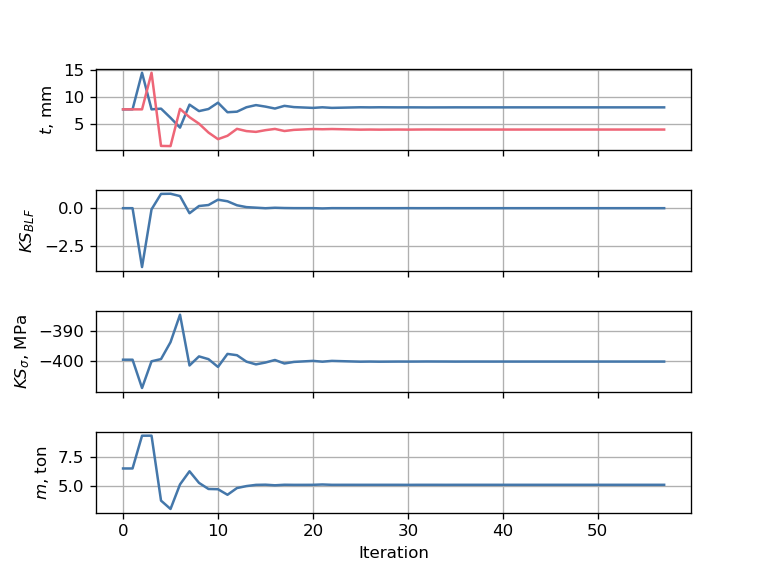

In [14]:
from resources.optimization_utils import plot_optimization_history

# Run optimization
linear_problem.setup()  # re-setup problem
linear_problem.set_solver_print(0)  # disable solver output
linear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    linear_problem.run_driver()  # run optimization
linear_problem.cleanup()  # shut down all recorders and clean up driver and model resources

# Plot optimization history
sol_105_opt_histories = plot_optimization_history(recorder_filepath)

Let's look at the final values of the design variables and the objective and constraint functions.

In [15]:
mass_percentage_variation = (sol_105_opt_histories['nastran_solver.mass'][-1, 0]/mass_0 - 1)*100
print("Final thicknesses (mm):")
print(sol_105_opt_histories['interp.t_cp'][-1, :])
print(f"""Final KS value of buckling load factor: {sol_105_opt_histories['nastran_solver.ks_buckling'][-1, 0]:.2f} N/m
Final KS value for stress: {sol_105_opt_histories['nastran_solver.ks_stress'][-1, 0]:.0f} MPa
Mass variation: {mass_percentage_variation:.1f} %""")

Final thicknesses (mm):
[8.06420192 3.9992008 ]
Final KS value of buckling load factor: 0.00 N/m
Final KS value for stress: -400 MPa
Mass variation: -21.7 %


The optimization achieves a 21.7% mass reduction with respect to the initial structure by slightly incrasing the root thickness and by almost halving the tip thickness.

Let's plot the critical buckling mode of the linearly optimized structure.

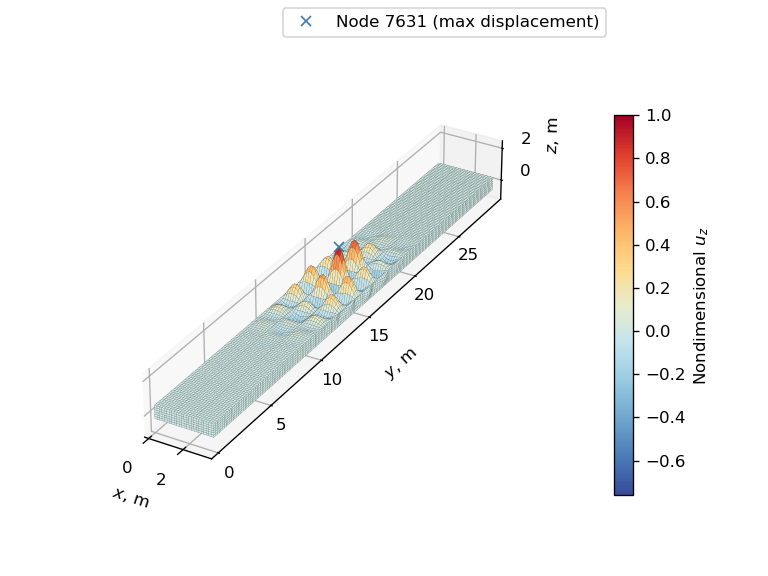

In [16]:
from pyNastran.op2.op2 import read_op2  # pyNastran OP2 reader function

# Read op2 file
sol_105_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)

# Plot buckling mode
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Find node where max displacement occurs for critical mode
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]

# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 80  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

The critical buckling mode of the linearly optimized structure involves the middle region of the top skin along the length of the CRM-like box beam. This result suggests that the optimizer has reinforced the most linear-buckling-critical region of the initial design, that is to say the root region, while decreasing the wall thickness of non-critical regions, such as the tip, until the middle region became critical.

At the same time, we observe that the optimization took almost 60 iterations to complete, but the values of the design variables, objective and constraint functions seemed to be converged after the first 30 iterations. Do we really need to run the optimization for that long?

We can adjust the computational time of the optimization by playing with the tolerance of the COBYLA optimizer. Inspecting the file `opt_report.html` produced by OpenMDAO for the optimization that we've just run, we can see that the tolerance for termination of the COBYLA algorithm is set by default to $10^{-6}$. What happens if we reduce it?

To discover it, we are going to run a number of optimizations varying the tolerance for termination from $10^{-1}$ to $10^{-5}$. For each optimization we will visualize the optimization history and print the values of the final design. Let's do it!

Optimization results with termination tolerance: 1e-01


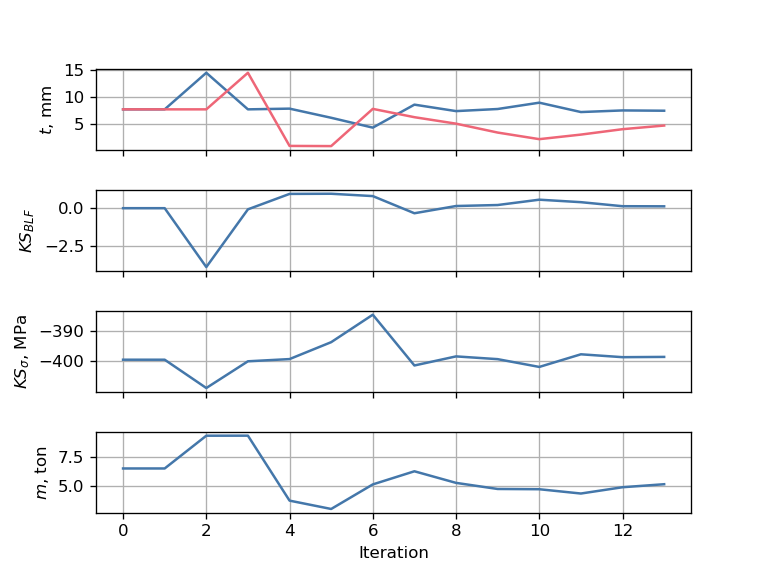

Final thicknesses (mm):
[7.44955706 4.7335842 ]
Final KS value of buckling load factor: 0.12 N/m
    Final KS value for stress: -399 MPa
    Mass variation: -20.9 %

Optimization results with termination tolerance: 1e-02


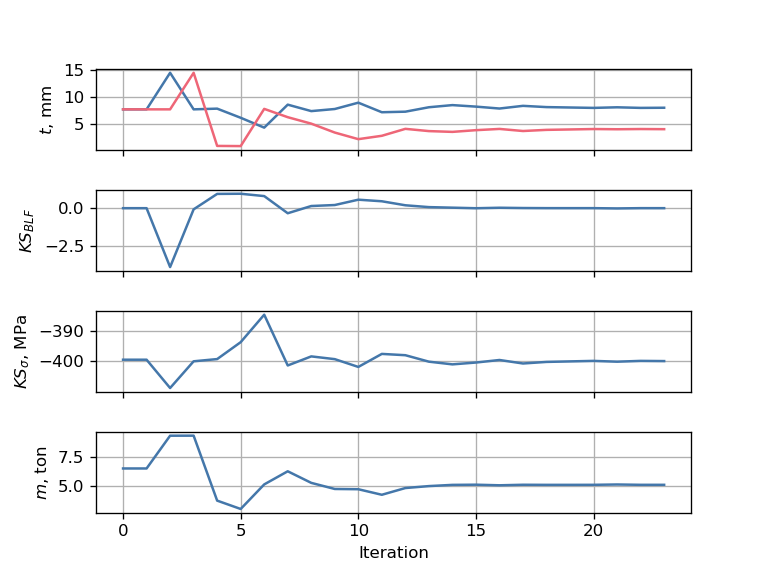

Final thicknesses (mm):
[7.99546278 4.06694691]
Final KS value of buckling load factor: 0.00 N/m
    Final KS value for stress: -400 MPa
    Mass variation: -21.7 %

Optimization results with termination tolerance: 1e-03


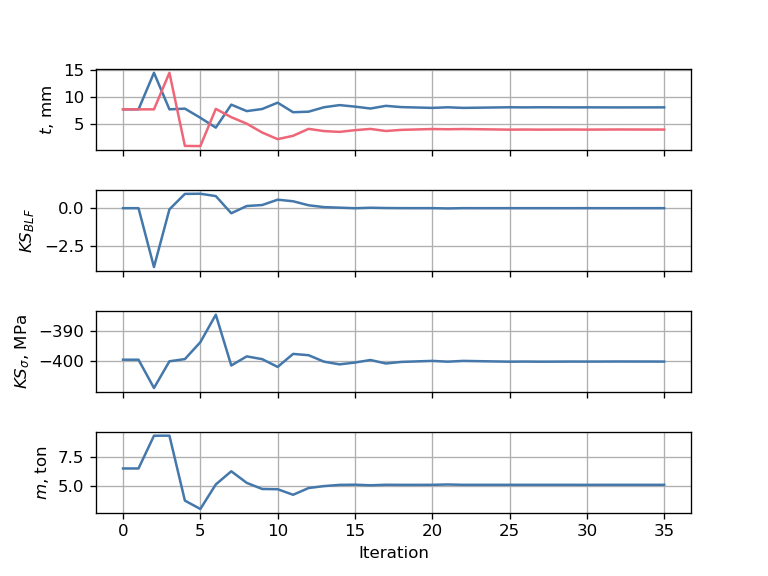

Final thicknesses (mm):
[8.06659956 3.99677649]
Final KS value of buckling load factor: 0.00 N/m
    Final KS value for stress: -400 MPa
    Mass variation: -21.7 %

Optimization results with termination tolerance: 1e-04


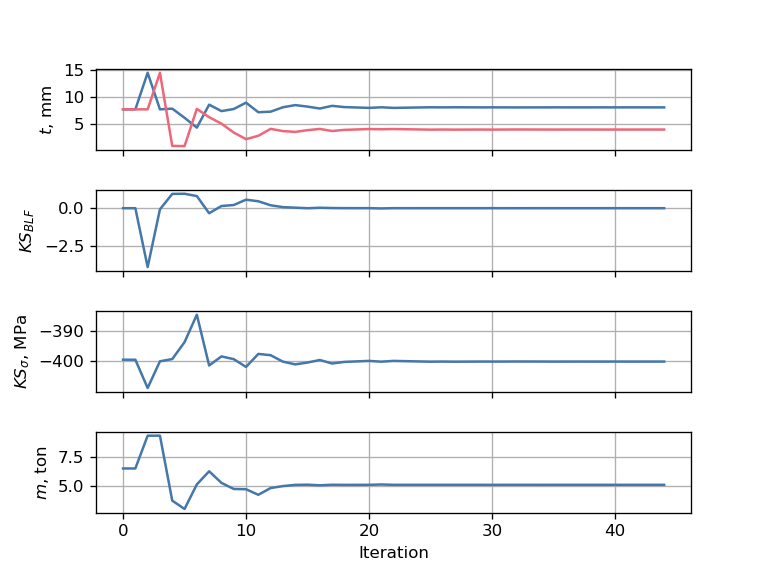

Final thicknesses (mm):
[8.06371456 3.99968763]
Final KS value of buckling load factor: 0.00 N/m
    Final KS value for stress: -400 MPa
    Mass variation: -21.7 %

Optimization results with termination tolerance: 1e-05


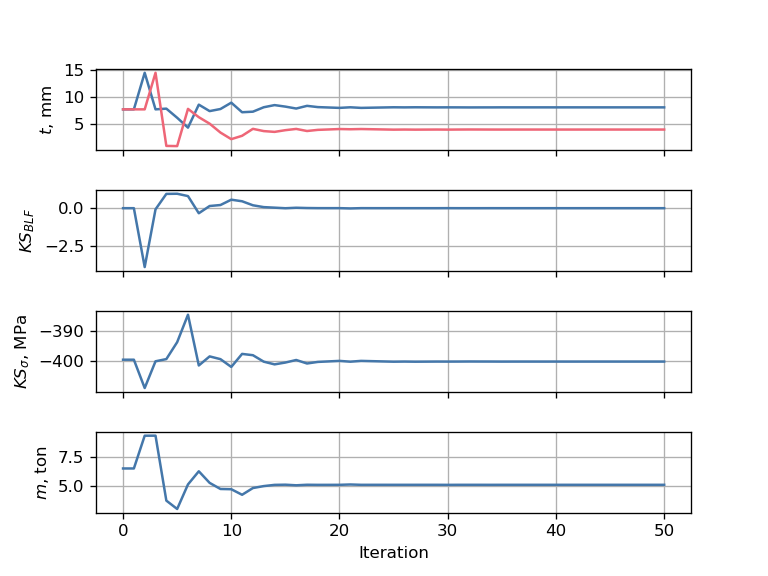

Final thicknesses (mm):
[8.06423604 3.99916683]
Final KS value of buckling load factor: 0.00 N/m
    Final KS value for stress: -400 MPa
    Mass variation: -21.7 %



In [17]:
# Define tolerances and initialize array of mass variations for later plot
tolerances = np.logspace(-1, -5, 5)
final_thicknesses = np.empty((len(tolerances) + 1, 2))  # initialize array with final thicknesses
final_thicknesses[-1, :] = sol_105_opt_histories['interp.t_cp'][-1, :]  # store thicknesses of default tolerance

# Iterate through the tolerances
for i, tol in enumerate(tolerances):
    # Set termination tolerance
    linear_problem.driver.options['tol'] = tol

    # Set default input values of sol_106 component
    input_name = f"sol_105_linear_optimization_tol{tol:.0e}"
    linear_problem.model.options['input_name'] = input_name

    # Add recorder
    recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.sql')
    recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
    linear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

    # Run optimization
    linear_problem.setup()  # re-setup problem
    linear_problem.set_solver_print(0)  # disable solver output
    linear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
    if False:  # set True or False to run optimization or not
        linear_problem.run_driver()  # run optimization
    linear_problem.cleanup()  # clean up problem

    # Plot optimization history
    print(f"Optimization results with termination tolerance: {tol:.0e}")
    sol_105_opt_histories = plot_optimization_history(recorder_filepath)

    # Store final thicknesses
    final_thicknesses[i, :] = sol_105_opt_histories['interp.t_cp'][-1, :]

    # Print optimization results
    mass_percentage_variation = (sol_105_opt_histories['nastran_solver.mass'][-1, 0]/mass_0 - 1)*100
    print("Final thicknesses (mm):")
    print(sol_105_opt_histories['interp.t_cp'][-1, :])
    print(f"""Final KS value of buckling load factor: {sol_105_opt_histories['nastran_solver.ks_buckling'][-1, 0]:.2f} N/m
    Final KS value for stress: {sol_105_opt_histories['nastran_solver.ks_stress'][-1, 0]:.0f} MPa
    Mass variation: {mass_percentage_variation:.1f} %\n""")

To understand the minimum termination tolerance that results in a converged final design, we plot the final thicknesses against the tolerance and we calculate the percentage difference with respect to the values obtained with the tightest tolerance.

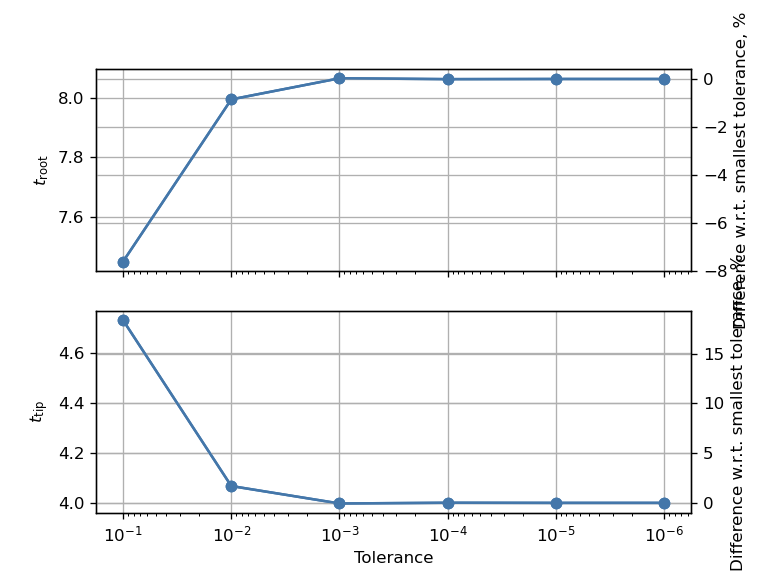

In [18]:
tolerances = np.append(tolerances, 1e-6)  # add default tolerance to the array
fig, axes = plt.subplots(2, 1, sharex=True)  # create figure with two subplots
ylabels = ["$t_\mathrm{root}$", "$t_\mathrm{tip}$"]  # labels for y-axis

# Iterate through the subplots
for i, ax, in enumerate(axes):
    # Plot thickness vs tolerance
    thickness_line = ax.semilogx(tolerances, final_thicknesses[:, i], 'o-')

    # Create a twin set of axes to plot percentage difference vs degrees of freedom
    twin_ax = ax.twinx()
    percentage_diff = (final_thicknesses[:, i]/final_thicknesses[-1, i] - 1)*100
    percentage_diff_line = twin_ax.plot(tolerances, percentage_diff, 'o-')

    # Set plot properties
    ax.set_ylabel(ylabels[i])
    ax.grid(True)
    twin_ax.set_ylabel("Difference w.r.t. smallest tolerance, %")
    twin_ax.grid(True)

# Set final plot properties and show
axes[1].invert_xaxis()
axes[1].set_xlabel("Tolerance")
plt.show()

The values of both thicknesses appear to be converged for a termination tolerance of $10^{-3}$. We will use this value for the nonlinear structural stability optimization.

In [19]:
linearly_optimized_thicknesses = final_thicknesses[2, :]  # store final design variables of the optimization employing the chosen termination tolerance

### Nonlinear response of linearly optimized structure <a name="nonlinear-response"></a>

Before moving on to the nonlinear structural stability optimization, let's take a look at the nonlinear response of the linearly optimized structure.

We complete the set up of the base `BDF` object for the nonlinear analysis by doing the following:
- request nonlinear stress calculation;
- create static load subcase;
- set up SOL 106 with the arc-length method;
- request the calculation of the tangent stiffness matrix eigenvalues.

Based on the results of our last notebook, we choose the following nonlinear analysis parameters for the arc-length method:
- load and displacement error functions;
- $\mathrm{EPSP}=10^{-5}$, $\mathrm{EPSU}=10^{-4}$;
- $\mathrm{MAXITER}=3$;
- $\mathrm{MAXBIS}=20$;
- $\mathrm{DESITER}=4$;
- $\mathrm{MINALR}=10^{-5}$;
- $\mathrm{MXINC}=100$.

In [20]:
METHOD_SET_ID = FORCE_SET_ID + 1  # id of the method for eigenvalue analysis
upper_eigenvalue = 100.  # upper bound for eigenvalues [N/mm] - set to 10^5 N/m to avoid convergence issues of Lanczos solver
sol_106_bdf = box_beam_bdf.__deepcopy__({})  # create a deep copy of the base BDF object for the linear optimization
sol_106_bdf.case_control_deck.subcases[0].add_result_type('NLSTRESS', 'ALL', ['PLOT'])  # store stress results of all elements in the op2 file
pynastran_utils.create_static_load_subcase(bdf_object=sol_106_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=FORCE_SET_ID)  # create subcase for static load
pynastran_utils.set_up_arc_length_method(bdf_object=sol_106_bdf, conv='PU', eps_p=1e-5, eps_u=1e-4, max_iter=3, max_bisect=20,
                                         desiter=4, minalr=1e-5, maxinc=100)  # set up arc length method
pynastran_utils.set_up_sol_106_with_kllrh_eigenvalues(bdf_object=sol_106_bdf, analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                      method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES, upper_eig=upper_eigenvalue)  # set up bdf for SOL 106 with KLLRH eigenvalues


Finally, we define an applied load equal to twice the design load, in order to explore the response of the linearly optimized structure beyond its linear buckling load.

In [21]:
sol_106_bdf.loads[FORCE_SET_ID][0].mag = DESIGN_LOAD*2  # apply twice the design load

We set up the OpenMDAO problem for the nonlinear analysis and we run the model with the thickness distribution of the linearly optimized structure.

In [22]:
# Set up nonlinear OpenMDAO problem
input_name = "sol_106_linear_optimization"  # default name for input file
sol_106_group = NastranGroup(bdf_object=sol_106_bdf, sigma_y=SIGMA_Y, analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                             input_name=input_name, run_flag=False)  # create NastranGroup object
sol_106_group.add_subsystem('interp', interp_comp)  # add spline component to the group
sol_106_group.connect('interp.t_val', 'nastran_solver.t_val')  # connect spline component output to the NastranSolver component input
nonlinear_problem = om.Problem(model=sol_106_group, name=input_name)
nonlinear_problem.setup()

# Run model with design variables of linearly optimized structure
nonlinear_problem.set_val('interp.t_cp', linearly_optimized_thicknesses)
nonlinear_problem.run_model()

Nastran job sol_106_linear_optimization.bdf completed
Wall time: 2362.0 s


Let's plot the results of the nonlinear analysis in terms of eigenvalue and load-displacement diagrams. For the latter, we consider the displacements of three nodes: the node at the root of the top skin where the maximum displacement occurs in the critical buckling mode of the initial structure, the node in the middle of the top skin where the maximum displacement occurs in the critical buckling mode of the linearly optimized structure, and the node at the tip.

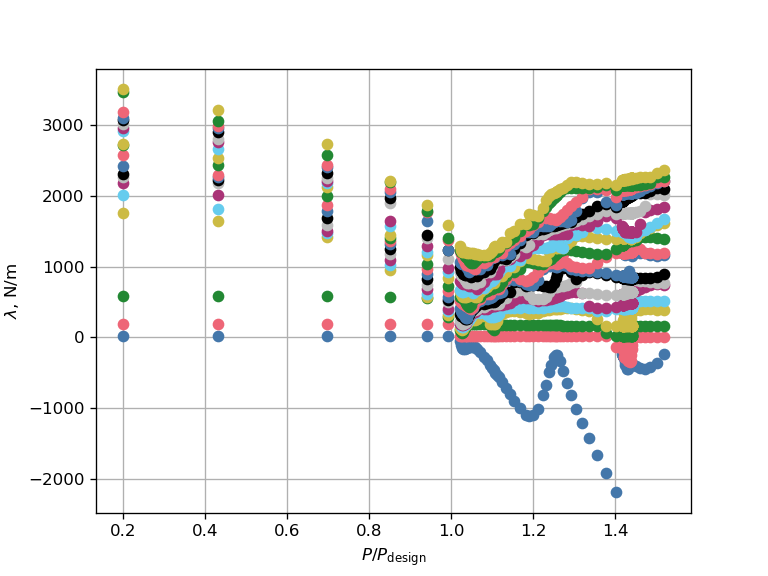

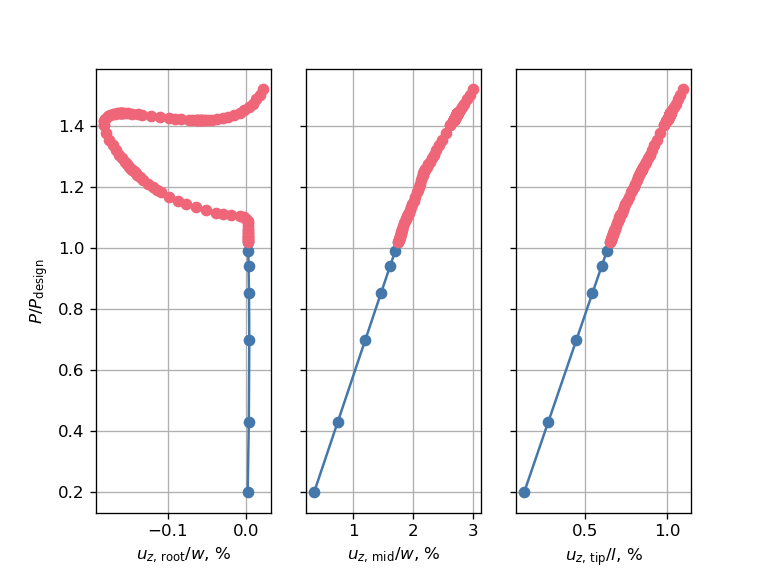

In [23]:
from resources import plot_utils  # import helper module for plotting

# Define constant variables for eigenvalue and load-displacement diagrams
PLOT_NODES_IDS = [ROOT_NODE_ID, max_displacement_node_id, TIP_MASTER_NODE_ID]  # ids of the nodes to be plotted
REFERENCE_LENGTHS = [W, W, L]  # reference lengths for nondimensionalization of displacements
DISPLACEMENT_LABELS = ["u_{z,\,\mathrm{root}}/w", "u_{z,\,\mathrm{mid}}/w", "u_{z,\,\mathrm{tip}}/l"]  # labels for displacements

# Define function to plot eigenvalues and load-displacement diagrams
def plot_eigenvalues_and_load_displacement_diagrams(op2, eigs):
    # Read applied load history and nondimensionalize
    end_plot_index = eigs.shape[1]  # for analysis that reached the maximum number of increments the eigevalues of the last increment are not printed in the f06 file
    _, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2)  # read load history from OP2 object
    subcase_key = next(iter(applied_loads))  # get key of subcase
    nondimensional_loads = applied_loads[subcase_key][:end_plot_index, Z_COMPONENT_INDEX]/DESIGN_LOAD  # nondimensionalize applied loads by design load
    
    # Plot eigenvalues vs applied load
    _, ax = plt.subplots()
    ax.plot(nondimensional_loads, eigs.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
    ax.set_ylabel("$\lambda$, N/m")
    ax.set_xlabel("$P/P_\mathrm{design}$")
    ax.grid(visible=True)
    plt.show()
    
    # Plot load-displacement diagrams
    _, axes = plt.subplots(1, len(PLOT_NODES_IDS), sharey=True)  # create figure with a number of subplots equal to the number of nodes to be plotted
    for i, ax in enumerate(axes):  # iterate through the subplots
        _, _, displacements = pynastran_utils.read_load_displacement_history_from_op2(
            op2_object=op2, displacement_node_id=PLOT_NODES_IDS[i])  # read displacements from OP2 object
        nondimensional_displacements = displacements[subcase_key][:end_plot_index, Z_COMPONENT_INDEX]/REFERENCE_LENGTHS[i]
        plot_utils.plot_2d_load_displacements_stability(eigs, ax, nondimensional_displacements*100,
                                                        nondimensional_loads, MARKERS[0], COLORS[0])
        ax.set_xlabel(f"${DISPLACEMENT_LABELS[i]}$, %")  # set x-axis label
        ax.grid(visible=True)  # show grid
    axes[0].set_ylabel("$P/P_\mathrm{design}$")  # set y-axis label
    plt.show()

# Plot eigenvalues and load-displacement diagrams for the linearly optimized structure
sol_106_op2 = nonlinear_problem['nastran_solver.op2']  # get op2 object
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)  # read eigenvalues from f06 file
plot_eigenvalues_and_load_displacement_diagrams(sol_106_op2, eigenvalues)

The analysis fails to converge to the prescribed load because it reaches the maximum number of iterations allowed for the arc-length method. In addition, we observe something unexpected: the structure appears to lose stability just after $P/P_\text{design}=1$ and it does not recover it for the investigated load range. At the same time, this loss of stability does not appear in the form of a load limit point, like for the initial design, but in the form of the unstable path of a supercritical pitchfork bifurcation, as the lowest eigenvalue remains negative for the rest of the analysis.

What is happening? Does the equilibrium manifold of the linearly optimized really feature a supercritical pitchfork bifurcation? Or did the arc-length solver jumped to a complementary path? The load-displacement diagrams do not show any evident discontinuity. However, in the eigenvalue diagram we notice that the size of the incrments decreases progressively towards $P/P_\text{design}=1$, and it becomes much smaller from the first negative eigenvalue onwards.

Something that we can do to understand whether the equilibrium manifold of the linearly optimized sturcture really features a supercritical pitchfork bifurcation is looking at the eigenvector associated to the first negative eigenvalue encountered during the analysis. In fact, in case of a supercritical pitchfork bifurcation, the eigenvector associated to the first negative eigenvalue should be the one describing the bifurcation mode, i.e. a mode that breaks the symmetry of the problem. On this matter, we know that the top-down symmetry of the problem is already broken by the bending load, so the only supercritical pitchfork bifurcation that might exist has to be associated to the front-rear symmetry, which is the only preserved symmetry under the considered load. Consequently, if the eigenvector of the first negative eigenvalue is associated to a shape that breaks the top-down symmetry, then the observed loss of stability will most probably be caused by a jump to a complementary path.

Let's run the analysis again changing the DMAP used to calculate the eigenvalues of the tangent stiffness matrix to save also the eigenvectors in the op2 file. In addition, we also cap the eigenvalues to a maximum of 2000 N/m, as during the last analysis we lost track of the lowest eigenvalue beyond $P/P_\text{design}=1.4$ because its value no longer fell within the smallest 20 (the Lanczos algorithm calculates the smallest-magnitude eigenvalues). Finally, we increase the maximum number of increments to 200.

After the analysis we plot again the eigenvalue and the load-displacement diagrams.

Nastran job sol_106_linear_optimization_mxinc200.bdf completed
Wall time: 5197.0 s


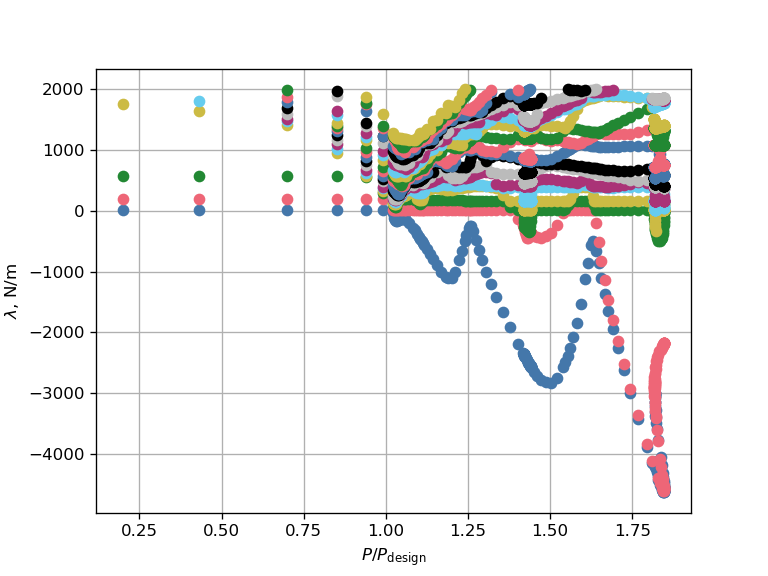

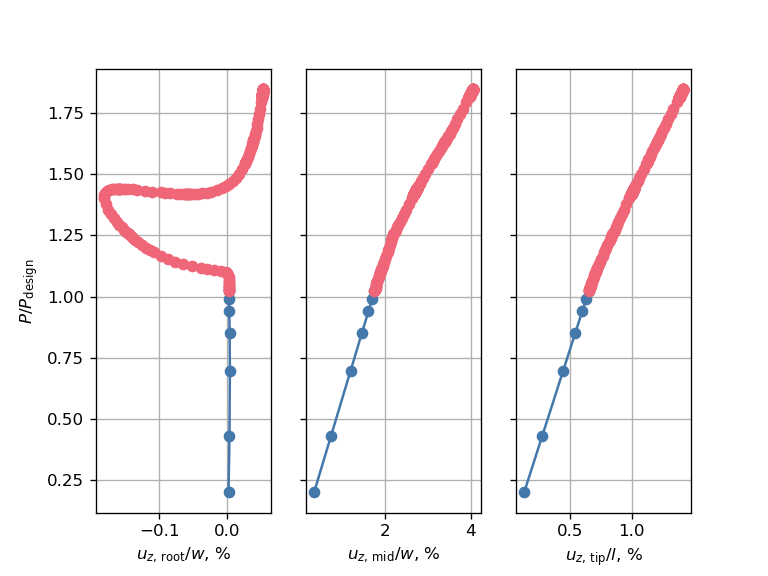

In [24]:
# Modify BDF object
dmap_eigenvectors = sol_106_bdf.executive_control_lines[1].replace("eigenvalues_nobuckle", "eigenvectors")  # get include string for eigenvectors DMAP
sol_106_bdf.executive_control_lines[1] = dmap_eigenvectors  # change DMAP command to store eigenvectors
upper_eigenvalue = 2000 * 1e-3  # upper bound for eigenvalues [N/mm] - set to 2000 N/m to avoid cutoff of negative eigenvalues
sol_106_bdf.params['UPPEREIG'].values[0] = pynastran_utils.eig_to_cycles(upper_eigenvalue)  # upper bound for eigenvalues must be specified in cycles
sol_106_bdf.nlpcis[FIRST_SUBCASE_ID].mxinc = 200  # increase maximum number of increments

# Run analysis and get op2 object
input_name = "sol_106_linear_optimization_mxinc200"
pynastran_utils.run_analysis(directory_path=ANALYSIS_DIRECTORY_PATH, bdf_object=sol_106_bdf, filename=input_name, run_flag=False)
sol_106_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)

# Assemble array of eigenvalues of tangent stiffness matrix
eigenvectors_key = next(iter(sol_106_op2.eigenvectors))
sequence_starts = np.where(sol_106_op2.eigenvectors[eigenvectors_key].lsdvmns == 1)[0]
sequence_ends = np.roll(sequence_starts, -1)
sequence_ends[-1] = len(sol_106_op2.eigenvectors[eigenvectors_key].lsdvmns)  # Setting the end of the last sequence to the end of the array
eigenvalues = np.column_stack([np.pad(sol_106_op2.eigenvectors[eigenvectors_key].eigrs[start:end], (0, NO_EIGENVALUES - (end - start)),
                                      mode='constant', constant_values=np.nan) for start, end in zip(sequence_starts, sequence_ends)])

# Plot eigenvalues and load-displacement diagrams
plot_eigenvalues_and_load_displacement_diagrams(sol_106_op2, eigenvalues)

Also in this case the analysis fails to converge to the prescribed load because it reaches the maximum number of allowed increments, however we can now see the negative eigenvalues fully tracked over the investigated load range.

Let's find the index of the increment where the first negative eigenvalue occurs during the analysis and let's plot the associated eigenvector.

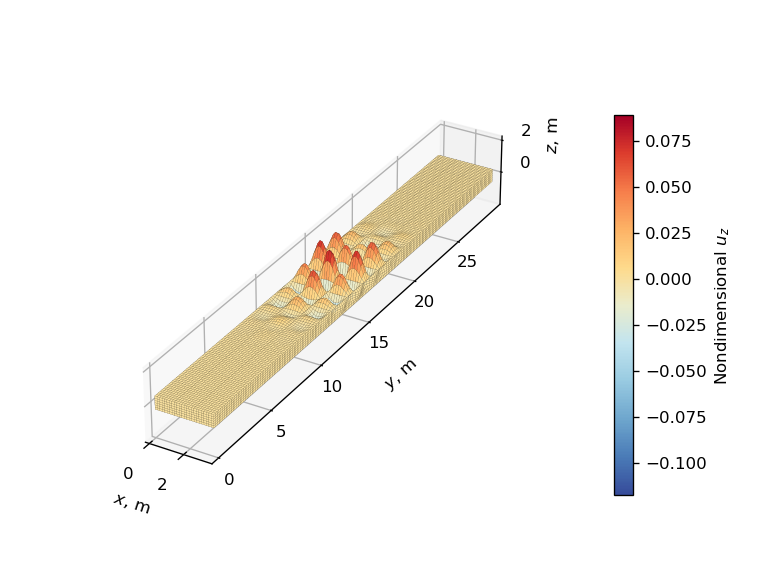

In [25]:
first_neg_eig_index = np.argmax(np.array(sol_106_op2.eigenvectors[eigenvectors_key].eigrs) < 0)  # the eigenvalues are given in a single list ordered from lowest to largest of each successive increment
amplification_factor = 20  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_106_op2, subcase_id=eigenvectors_key, mode_number=first_neg_eig_index + 1,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax, cbar)
plt.show()

The above eigenvector is analogous to the shape of the critical buckling mode. This finding makes sense, as the linear buckling analysis can be thought of as the attempt of finding the eigenvalue of the initial stiffness matrix that decreases most rapidly and approaches zero before the others.

The fact that the shape involves the mid part of the top skin suggests that there actually isn't any supercritical pitchfork bifurcation and that the arc-length solver jumped to a complementary path. In fact, we know that, because of the bending, the compression experienced by the top skin can only result in a broken supercritical pitchfork, as the top-down symmetry of the top skin's stresses is broken by the bending itself.

We inspect the f06 file of our first nonlinear analysis and we look at the convergence of the increment where the first negative eigenvalue is found.

```
                        - - - CONVERGENCE  FACTORS - - -                      - - - LINE SEARCH DATA - - -
0ITERATION      EUI         EPI         EWI      LAMBDA       DLMAG       FACTOR     E-FIRST     E-FINAL   NQNV  NLS  ENIC  NDV  MDV

         3  7.9153E-05  1.1457E-06  2.0453E-12  1.0000E-01  1.9792E-06  1.0000E+00  0.0000E+00  0.0000E+00    0    0          0    1
 *** USER INFORMATION MESSAGE 6186 (NCONVG)
     *** SOLUTION HAS CONVERGED ***
         SUBID    1     LOOPID    7     LOAD STEP    0.511     LOAD FACTOR 0.51059832
```

The increment converges at the third iteration with a displacement error of $7.9\cdot 10^{-5}$ and a load error of $1.1\cdot 10^{-6}$.

What we can do at this point is trying to repeat the same analysis with tighter convergence tolerances, setting $\mathrm{EPSU}=10^{-5}$ and $\mathrm{EPSP}=10^{-6}$. We also increase the maximum number of increments to 300, based on the results of our last analysis.

Nastran job sol_106_linear_optimization_epsu1e-5.bdf completed
Wall time: 4752.0 s


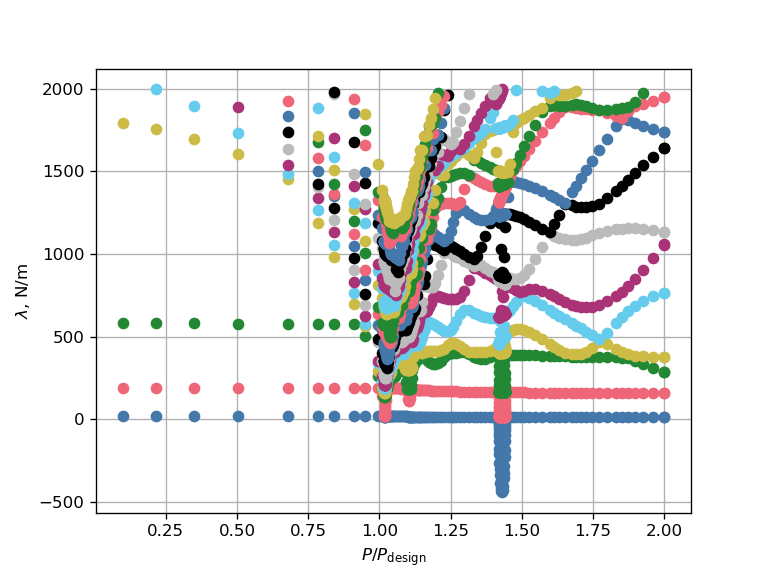

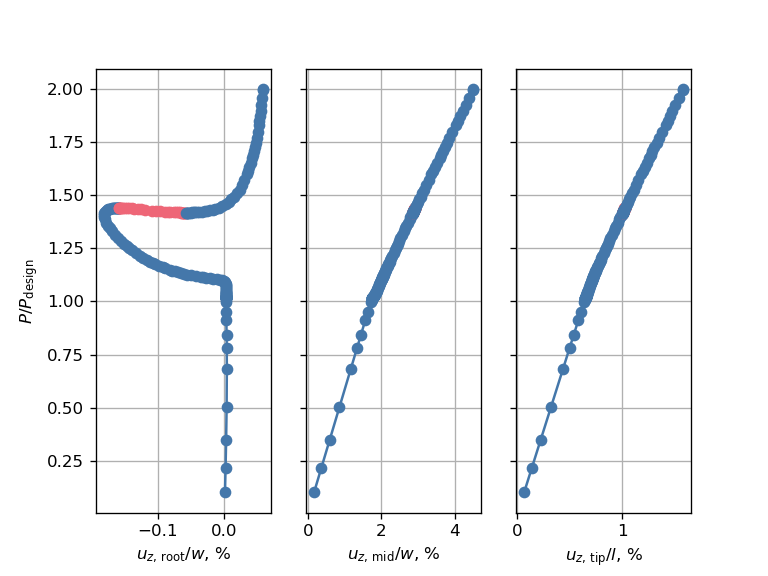

In [26]:
# Modify input
sol_106_bdf.nlparms[FIRST_SUBCASE_ID].eps_u = 1e-5
sol_106_bdf.nlparms[FIRST_SUBCASE_ID].eps_p = 1e-6
sol_106_bdf.nlpcis[FIRST_SUBCASE_ID].mxinc = 300

# Run analysis and get op2 object
input_name = "sol_106_linear_optimization_epsu1e-5"
pynastran_utils.run_analysis(directory_path=ANALYSIS_DIRECTORY_PATH, bdf_object=sol_106_bdf, filename=input_name, run_flag=False)
sol_106_op2 = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)

# Assemble array of eigenvalues of tangent stiffness matrix
eigenvectors_key = next(iter(sol_106_op2.eigenvectors))
sequence_starts = np.where(sol_106_op2.eigenvectors[eigenvectors_key].lsdvmns == 1)[0]
sequence_ends = np.roll(sequence_starts, -1)
sequence_ends[-1] = len(sol_106_op2.eigenvectors[eigenvectors_key].lsdvmns)  # Setting the end of the last sequence to the end of the array
eigenvalues = np.column_stack([np.pad(sol_106_op2.eigenvectors[eigenvectors_key].eigrs[start:end], (0, NO_EIGENVALUES - (end - start)),
                                      mode='constant', constant_values=np.nan) for start, end in zip(sequence_starts, sequence_ends)])

# Plot eigenvalues and load-displacement diagrams
plot_eigenvalues_and_load_displacement_diagrams(sol_106_op2, eigenvalues)

Eureka! The results of the analysis no longer show a loss of stability just after $P/P_\text{design}=1$. Instead the loss of stability occurs approximately at $P/P_\text{design}=1.44$ and it is characterized by a load limit point, analogously to the initial structure. We also observe that the increase of the root displacement, associated to the broken supercritical pitchfork of the corresponding rib-stiffener bay, does not occur across $P/P_\text{design}=1$, but slightly above such load. At the same time, there is an evident change of slope at $P/P_\text{design}=1$ for the load-displacement curve of the mid node, which must in turn be associated to the broken supercritical pitchfork of the corresponding rib-stiffener bay. This observation is in agreement with the fact that the critical buckling mode obtained from the linear analysis involves mainly the middle rib-stiffener bays of the CRM-like box beam.

Before moving to the nonlinear structural stability optimization, we store the input name, the `OP2` object and the tangent stiffness matrix eigenvalues of the last analysis in order to facilitate the comparison between the linearly and the nonlinearly optimized structures.

In [27]:
key = "linearly optimized structure"
input_name_dict = {key: input_name}
sol_106_op2_dict = {key: sol_106_op2}
eigenvalues_dict = {key: eigenvalues}

## Nonlinear structural stability optimization <a name="nonlinear-optimization"></a>

***

We can finally run the optimization with nonlinear structural stability constraints. We restore the magnitude of the applied load to that of the design load, change the DMAP to stop the analysis after the first negative eigenvalue, and restore the original upper bound for the eigenvalues of the tangent stiffness matrix.

In [28]:
sol_106_bdf.loads[FORCE_SET_ID][0].mag = DESIGN_LOAD  # restore design load
dmap_stop = sol_106_bdf.executive_control_lines[1].replace("eigenvectors", "eigenvalues_stop")  # get include string for DMAP stopping the analysis after the first negative eigenvalue is found
sol_106_bdf.executive_control_lines[1] = dmap_stop  # change DMAP command to store eigenvectors
upper_eigenvalue = upper_eigenvalue = 100.  # restore previous upper bound for eigenvalues [N/mm] (10^5 N/m)
sol_106_bdf.params['UPPEREIG'].values[0] = pynastran_utils.eig_to_cycles(upper_eigenvalue)  # upper bound for eigenvalues must be specified in cycles

Now we set the starting design variables equal to those of the linearly optimized structure, and we run the nonlinear analysis on this structure to find the appropriate scaling factors for the objective and constraint functions.

In [29]:
# Run model with initial design variable
input_name = "sol_106_nonlinear_optimization_start"
nonlinear_problem.model.nastran_solver.options['input_name'] = input_name
nonlinear_problem.set_val('interp.t_cp', linearly_optimized_thicknesses)
nonlinear_problem.run_model()

# Record initial objective and constraint function values
mass_0 = nonlinear_problem['nastran_solver.mass'][0]
ks_stability_0 = nonlinear_problem["nastran_solver.ks_stability"][0]
ks_stress_0 = nonlinear_problem["nastran_solver.ks_stress"][0]
print(f"""Initial mass: {mass_0*1e3:.0f} kg
Initial KS value for stability: {ks_stability_0:.1f} N/m
Initial KS value for stress: {ks_stress_0:.0f} MPa""")

Nastran job sol_106_nonlinear_optimization_start.bdf completed
Wall time: 143.0 s
Initial mass: 5106 kg
Initial KS value for stability: -19.3 N/m
Initial KS value for stress: -400 MPa


We finally set up the optimization problem, run the optimization, and plot the optimization history.

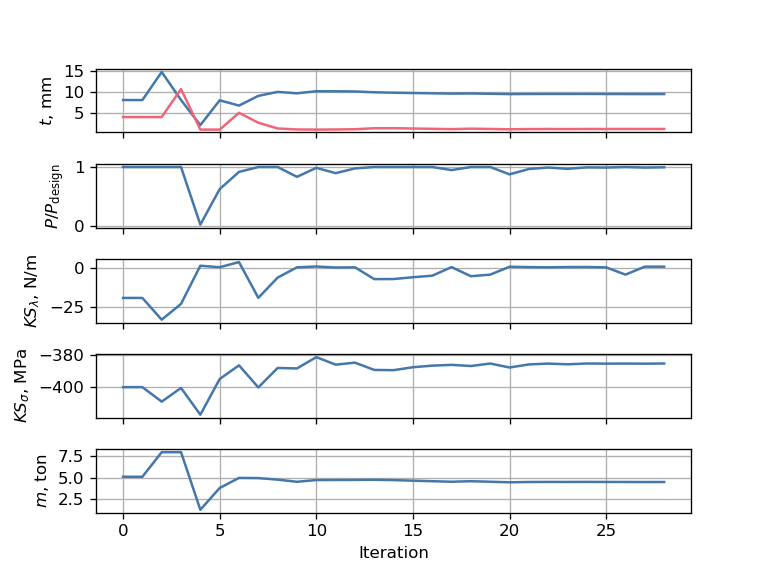

In [30]:
# Set default input values of nastran_solver component
input_name = "sol_106_nonlinear_optimization"
nonlinear_problem.model.options['input_name'] = input_name  # restore default input name for analyses during optimization
nonlinear_problem.model.set_input_defaults('interp.t_cp', linearly_optimized_thicknesses)  # initial thickness

# Choose optimizer
nonlinear_problem.driver = om.ScipyOptimizeDriver()
nonlinear_problem.driver.options['optimizer'] = 'COBYLA'
nonlinear_problem.driver.options['tol'] = 1e-3

# Add design variable, objective and constraints
nonlinear_problem.model.add_design_var('interp.t_cp', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=t0)  # scale thickness so that the lower bound is 0 and initial value is 1
nonlinear_problem.model.add_objective('nastran_solver.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
nonlinear_problem.model.add_constraint('nastran_solver.ks_stability', upper=0., ref=np.abs(ks_stability_0))  # scale KS function for nonlinear structural stability so that the initial value is 1
nonlinear_problem.model.add_constraint('nastran_solver.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1
nonlinear_problem.model.add_constraint('nastran_solver.applied_load', lower=DESIGN_LOAD*.99, ref=DESIGN_LOAD)  # scale applied load so that design

# Add recorder to the driver
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
nonlinear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

# Run optimization
nonlinear_problem.setup()  # re-setup problem
nonlinear_problem.set_solver_print(0)  # disable solver output
nonlinear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if False:  # set True or False to run optimization or not
    nonlinear_problem.run_driver()  # run optimization
nonlinear_problem.cleanup()  # shut down all recorders and clean up driver and model resources

# Plot optimization history
sol_106_opt_histories = plot_optimization_history(recorder_filepath)

The optimization does not end on a feasible design, given the positive value of the structural stability constraint function. For this reason, we find the last feasible design and print the associated values of design variables, constraint functions and mass variation with respect to the linearly optimized structure.

In [31]:
feasible_design_index = np.where(sol_106_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
mass_percentage_variation = (sol_106_opt_histories['nastran_solver.mass'][feasible_design_index, 0]/mass_0 - 1)*100
feasible_thickness_array = sol_106_opt_histories['interp.t_cp'][feasible_design_index, :]
print("Final thicknesses (mm):")
print(feasible_thickness_array)
print(f"""Final KS value of nonlinear structural stability: {sol_106_opt_histories['nastran_solver.ks_stability'][feasible_design_index, 0]:.2f} N/m
Final KS value for stress: {sol_106_opt_histories['nastran_solver.ks_stress'][feasible_design_index, 0]:.0f} MPa
Final nondimensional applied load: {sol_106_opt_histories['nastran_solver.applied_load'][feasible_design_index, 0]:.2f}
Mass variation: {mass_percentage_variation:.1f} %""")

Final thicknesses (mm):
[9.49728199 1.15220456]
Final KS value of nonlinear structural stability: -4.49 N/m
Final KS value for stress: -386 MPa
Final nondimensional applied load: 1.00
Mass variation: -11.7 %


With the last feasible design, the optimization achieves a 11.7% mass reduction with respect to the linearly optimized structure, with a final thickness distribution ranging from 9.5 mm at the root to 1.2 mm at the tip. Comparing this distribution to the initial structure with uniform wall thickness and to the results of the linear buckling optimization, we observe that the nonlinear structural stability optimization has further reinforced the thickness at the root and further reduced the thickness at the tip.

Let's run the analysis of the last feasible point and compare the eigenvalue diagram of the model with the original mesh to that with the refined mesh.

Nastran job sol_106_nonlinear_optimization_feasible.bdf completed
Wall time: 2748.0 s


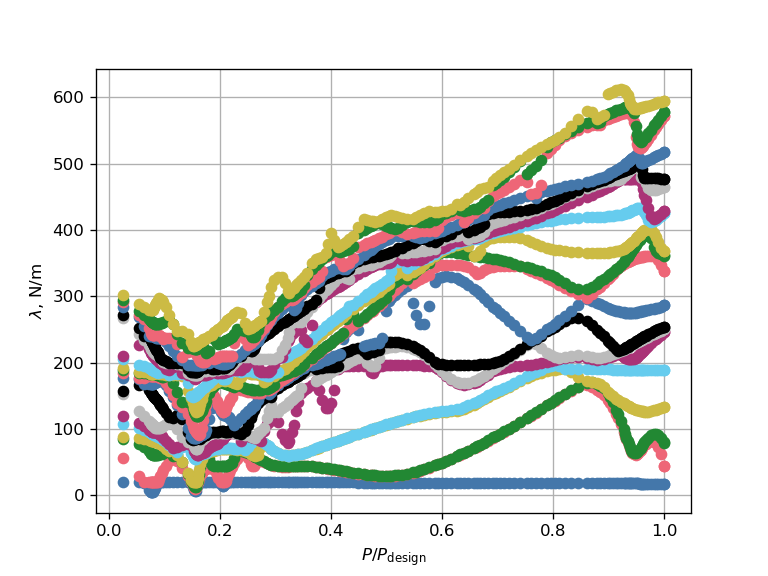

In [32]:
# Run analysis
key = "nonlinearly optimized structure"
input_name_dict[key] = "sol_106_nonlinear_optimization_feasible"
nonlinear_problem.model.nastran_solver.options['input_name'] = input_name_dict[key]  # change input name for analysis of initial structure
nonlinear_problem.set_val('interp.t_cp', feasible_thickness_array)
nonlinear_problem.run_model()

# Retrieve OP2 object of nonlinear analysis
sol_106_op2_dict[key] = nonlinear_problem['nastran_solver.op2']

# Read load and displacement history of benchmark analysis from op2 file
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_dict[key])
nondimensional_loads = {key: applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD}

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name_dict[key] + '.f06')  # path to .f06 file
eigenvalues_dict[key] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(nondimensional_loads[key], eigenvalues_dict[key].T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)
plt.show()

A number of local minima can be observed especially for $P/P_\text{design}<0.3$. These local minima are most probably associated to the broken supercritical pitchfork of some rib-stiffener bays of the top skin. For $P/P_\text{design}>0.3$ we observe that many eigenvalues have an increasing trend, suggesting that the associated principal stiffness direction becomes progressively stiffer as the structure is loaded. However, the lowest eigenvalue, which is the one associated to the global bending of the CRM-like box beam, has a slight decreasing trend, which means that the structure becomes globally softer as it is loaded. We expect to see this effect in the load-displacement diagram of the tip node.

Looking at the lowest eigenvalue at the design load we notice that the structure has still a considerable margin of stability, meaning that the optimization stopped before exploiting the full stability capacity of the structure and that some more mass could be saved by reducing the thickness.

Our next step in the exploration of the results of the nonlinear structural stability optimization is to compare the load-displacement diagrams of the linearly and nonlinearly optimized structures. However, before plotting the load-displacement diagram of the nonlinearly optimized structure, we calculate its linear buckling load and plot the associated critical buckling mode.

Nastran job sol_105_nonlinear_optimization_feasible.bdf completed
Wall time: 15.0 s
P_SOL 105/P_design = 0.08


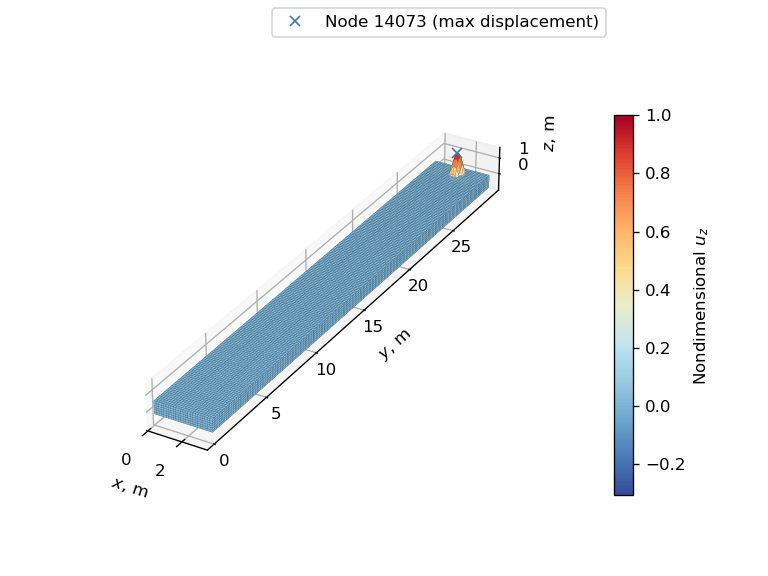

In [33]:
# Run linear buckling analysis
linear_problem.model.nastran_solver.options['input_name'] = "sol_105_nonlinear_optimization_feasible"  # change input name for analysis of initial structure
linear_problem.set_val('interp.t_cp', feasible_thickness_array)
linear_problem.run_model()

# Find critical buckling load
sol_105_op2 = linear_problem['nastran_solver.op2']
buckling_load_factor = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
print(f"P_SOL 105/P_design = {buckling_load_factor:.2f}")

# Plot buckling mode
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Find node where max displacement occurs for critical mode
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]

# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 80  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

The linear buckling load of the nonlinearly optimized structure amounts to only 8% of the design load and, even more surprisingly, the corresponding critical buckling mode involves the tip region of the bottom skin! This is totally unexpected, as the bottom skin is supposed to be in a state of tension under the considered load, and this state should not cause any buckling. This finding suggests that the first local minimum observed earlier in the eigenvalue diagram is most probably associated to an eigenvector analogous to the critical buckling mode found here.

What might be causing the result above? One possible explanation lies in how the load is introduced into the structure. In fact, the the load is introduced at an artificial node at the center of the tip section, which is connected to the nodes on the edge of the section through a multipoint constraint, in the form of a `RBE3` card. In addition the load is introduced as a vertical non-follower force, meaning that it keeps pointing in the positive $z$-direction as the structure deforms.

This way of introducing the load is rather artificial, and it might cause weird compression fields over the elements close to nodes included in the multipoint constraint. This in turn might cause the linear analysis to predict buckling over the tip of the bottom skin.

Successively, we plot the load displacement diagrams comparing the response of the nonlinearly optimized structure to that of the linearly optimized one.

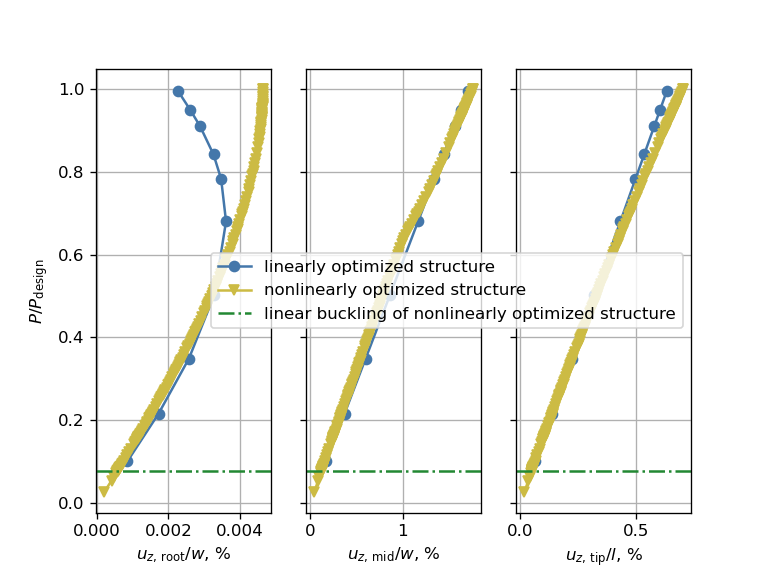

In [34]:
# Store nondimensional loads of linearly optimized structure
key = "linearly optimized structure"
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_dict[key])
subcase_dict = {key: next(iter(applied_loads)),
                "nonlinearly optimized structure": FIRST_SUBCASE_ID}
nondimensional_loads[key] = applied_loads[subcase_dict[key]][:, Z_COMPONENT_INDEX]/DESIGN_LOAD

# Plot load-displacement diagrams
_, axes = plt.subplots(1, len(PLOT_NODES_IDS), sharey=True)  # create figure with a number of subplots equal to the number of nodes to be plotted
for i, ax in enumerate(axes):  # iterate through the subplots
    stable_lines = []  # list to store proxy artists for the legend
    for color_index, design_key in enumerate(sol_106_op2_dict):
        plot_indices = nondimensional_loads[design_key] <= 1  # limit plot to applied loads less than or equal to design load
        _, _, displacements = pynastran_utils.read_load_displacement_history_from_op2(
            op2_object=sol_106_op2_dict[design_key], displacement_node_id=PLOT_NODES_IDS[i])  # read displacements from OP2 object
        nondimensional_displacements = displacements[subcase_dict[design_key]][plot_indices, Z_COMPONENT_INDEX]/REFERENCE_LENGTHS[i]
        plot_utils.plot_2d_load_displacements_stability(eigenvalues_dict[design_key][:, plot_indices], ax, nondimensional_displacements*100,
                                                        nondimensional_loads[design_key][plot_indices], MARKERS[color_index], COLORS[color_index])
        stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[color_index], color=COLORS[color_index], label=design_key))  # create proxy artist for the legend
    ax.axhline(y=buckling_load_factor, color=GLASS_CEILING_COLOR, linestyle='-.')  # plot glass ceiling
    ax.set_xlabel(f"${DISPLACEMENT_LABELS[i]}$, %")  # set x-axis label
    ax.grid(visible=True)  # show grid

# Add proxy artist for unstable lines and create legend
glass_ceiling_line = Line2D([0], [0], linestyle='-.', color=GLASS_CEILING_COLOR, label="linear buckling of nonlinearly optimized structure")
axes[2].legend(handles=stable_lines + [glass_ceiling_line])

# Set y-axis label and show plot
axes[0].set_ylabel("$P/P_\mathrm{design}$")
plt.show()

The different response of the nonlinearly optimized structure is visible for all the considered nodes. Because of the larger thickness at the root with respect to the linearly optimized structure, we can see that root displacement of the nonlinearly optimized structure exhibits a nonlinear behavior to a smaller extent. The mid displacement is charaterized initially by a larger slope compared to the linearly optimized structure, until a change of slope occurs at approximately $P/P_\text{design}=0.65$. The tip displacement is characterized by a progressively reducing slope, which shows how the nonlinearly optimized structure becomes globally softer than the linealry optimized one as it is loaded.

Finally, we compare the deformation at the design load of linearly and nonlinearly optimized structures, coloring the elements with their average rotation about the $x$ axis.

Deformation at design load of linearly optimized structure:


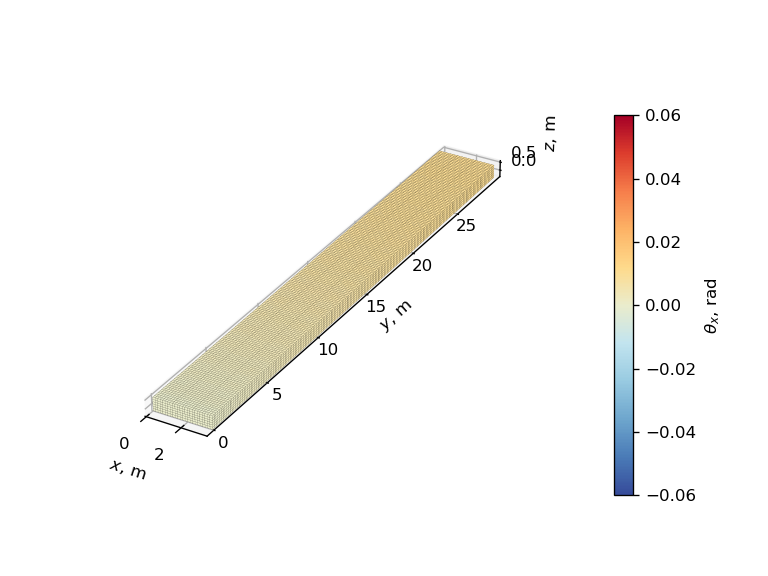

Deformation at design load of nonlinearly optimized structure:


c:\Users\qa21944\Github\phd-jupyter-notebooks\notebooks\resources\pynastran_utils.py:319: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


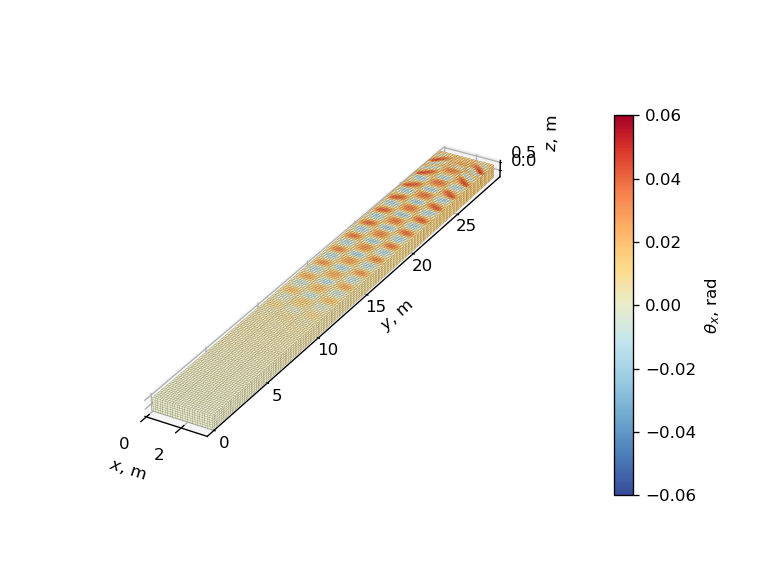

In [35]:
clim = [-0.06, 0.06]  # color limits for deformation plots
for key in sol_106_op2_dict:  # loop through the linearly and nonlinearly optimized structures
    print(f"Deformation at design load of {key}:")
    design_load_index = np.argmin(np.abs(nondimensional_loads[key] - 1))  # find index of design load
    _, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_dict[key], subcase_id=subcase_dict[key], load_step=design_load_index + 1,
                                                          displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3, clim=clim)  # plot deformation converting from mm to m
    adjust_3d_plot(ax, cbar)
    plt.show()

The deformation of the linearly optimized structure is analogous to that of a linear beam, while for the nonlinearly optimized sturcture we can observe a buckling-like pattern from the middle to the tip region of the top skin. In addition, towards the tip of the CRM-like box beam, it is also possible to observe that the half-waves characterizing the deformation of the front and rear rib-stiffener bays are oriented at approximately 45 degrees with respect to the beam’s width. This is most probably driven by the
compression in the upper part of the two spars, that become very thin towards the tip.

### Mesh verification of nonlinearly optimized structure <a name="mesh-verification"></a>

Given the unexpected results of the linear buckling analysis of the nonlinearly optimized structure and the new deformation pattern observed towards the tip, we decide to run a mesh verification study to understand the influence of the mesh on the results of the nonlinear structural stability optimization.

We create a new model of the CRM-like box beam using a mesh obtained by halving the target element length used for the original model.

In [36]:
# Create mesh with half of the original target element length
box_beam_refined_mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs_and_stiffeners(
    width=W, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=element_length/2)

# Create BDF object and apply concentrated load at the tip
box_beam_refined_mesh_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t0, box_beam_refined_mesh.points,
                                                                 box_beam_refined_mesh.faces.reshape(-1, 5)[:, 1:])

# Add PSHELL cards to define design patches
box_beam_utils.define_property_patches(bdf_input=box_beam_refined_mesh_bdf, ribs_y_locations=ribs_y_locations, stiffeners_x_locations=stiffeners_x_locations)

# Define master node of tip section and connect it to the nodes on the edge of the section with a RBE3 element
refined_mesh_tip_master_node_id = len(box_beam_refined_mesh_bdf.nodes) + 1
box_beam_refined_mesh_bdf.add_grid(refined_mesh_tip_master_node_id, [W/2, L, 0.])
tip_edge_nodes_ids = [nid for nid in box_beam_refined_mesh_bdf.nodes if (np.abs(box_beam_refined_mesh_bdf.nodes[nid].xyz[1] - L) < nodes_tolerance) &
                      (np.abs((box_beam_refined_mesh_bdf.nodes[nid].xyz[0]) < nodes_tolerance) | (np.abs(box_beam_refined_mesh_bdf.nodes[nid].xyz[0] - W) < nodes_tolerance) |
                      (np.abs(box_beam_refined_mesh_bdf.nodes[nid].xyz[2] - h/2) < nodes_tolerance) | (np.abs(box_beam_refined_mesh_bdf.nodes[nid].xyz[2] + h/2) < nodes_tolerance))]  # ids of the nodes on the edge of the tip section
rbe3_eid = len(box_beam_refined_mesh_bdf.elements) + 1
box_beam_refined_mesh_bdf.add_rbe3(eid=rbe3_eid, refgrid=refined_mesh_tip_master_node_id, refc='123456', weights=[1.],
                       comps=['123456'], Gijs=[tip_edge_nodes_ids])

# Add tip force
force_direction = [0., 0., 1.]
box_beam_refined_mesh_bdf.add_force(sid=FORCE_SET_ID, node=refined_mesh_tip_master_node_id, mag=DESIGN_LOAD, xyz=force_direction)

subcase=0 already exists...skipping


FORCE         11   47368          12517.      0.      0.      1.

Then we set up the `BDF` object for the linear buckling analysis, create the `NastranGroup` object and set up the OpenMDAO problem.

In [37]:
# Set up BDF object for linear buckling analysis
sol_105_refined_mesh_bdf = box_beam_refined_mesh_bdf.__deepcopy__({})
sol_105_refined_mesh_bdf.case_control_deck.subcases[0].add_result_type('STRESS', 'ALL', ['PLOT'])  # store stress results of all elements in the op2 file
pynastran_utils.set_up_sol_105(bdf_object=sol_105_refined_mesh_bdf, static_load_set_id=FORCE_SET_ID, no_eigenvalues=NO_EIGENVALUES)  # set up bdf for SOL 105

# Create NastranGroup object and set up OpenMDAO problem
no_elements_refined_mesh = len(sol_105_refined_mesh_bdf.elements)
input_name = f"sol_105_initial_structure_{no_elements_refined_mesh}_elements"
sol_105_group = NastranGroup(bdf_object=sol_105_refined_mesh_bdf, sigma_y=SIGMA_Y, analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                             input_name=input_name, run_flag=False)  # create NastranGroup object
sol_105_group.add_subsystem('interp', interp_comp)  # add spline component to the group
sol_105_group.connect('interp.t_val', 'nastran_solver.t_val')  # connect spline component output to the NastranSolver component input
linear_problem = om.Problem(model=sol_105_group, name=input_name)
linear_problem.setup()

The first analysis that we run on the model with the refined mesh is the linear buckling analysis of the initial design, charaterized by a uniform thickness distribution. We plot the critical buckling mode and find the node where the maximum displacement occurs, in order to monitor the root displacement in the nonlinear analysis.

Nastran job sol_105_initial_structure_48300_elements.bdf completed
Wall time: 52.0 s


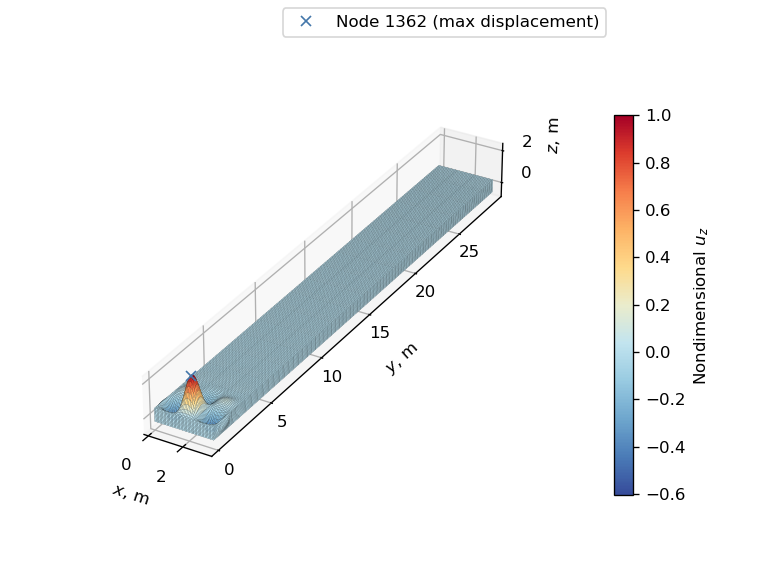

In [38]:
# Set initial thickness values and run analysis
linear_problem.set_val('interp.t_cp', initial_thickness_vector)
linear_problem.run_model()

# Find node where max displacement occurs
sol_105_op2 = linear_problem['nastran_solver.op2']
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
refined_mesh_max_displacement_node_id = sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]

# Plot buckling mode
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2,
                                                 subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
refined_mesh_max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_index].xyz*1e-3 +\
    sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(refined_mesh_max_displacement_node_xyz[0],
        refined_mesh_max_displacement_node_xyz[1],
        refined_mesh_max_displacement_node_xyz[2],
        "x", label=f"Node {refined_mesh_max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

As expected, the critical buckling mode of the model employing the refined mesh and a uniform thickness distribution is analogous to that of the model with the original mesh.

Now we run the linear buckling analysis of the model with the thickness distribution of the nonlinearly optimized structure.

Nastran job sol_105_nonlinear_optimization_48300_elements.bdf completed
Wall time: 168.0 s


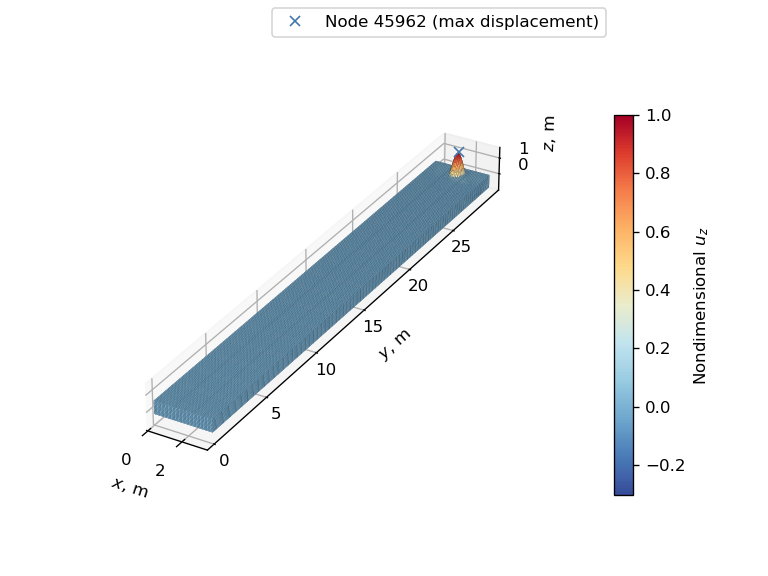

In [39]:
# Set initial thickness values and run analysis
linear_problem.set_val('interp.t_cp', feasible_thickness_array)
linear_problem.model.nastran_solver.options['input_name'] = f"sol_105_nonlinear_optimization_{no_elements_refined_mesh}_elements"
linear_problem.run_model()

# Find node where max displacement occurs
sol_105_op2 = linear_problem['nastran_solver.op2']
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]

# Plot buckling mode
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2,
                                                 subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
refined_mesh_max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_index].xyz*1e-3 +\
    sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(refined_mesh_max_displacement_node_xyz[0],
        refined_mesh_max_displacement_node_xyz[1],
        refined_mesh_max_displacement_node_xyz[2],
        "x", label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

Also the critical buckling mode of the model employing the thickness distribution of the nonlinearly optimized structure is analogous to that obtained with the original mesh, confirming the buckling of the tip region of the bottom skin.

Successively, we move to the nonlinear analysis. We set up the `BDF` object to calculate the eigenvalues of the tangent stiffness matrix at every converged iteration, create the `NastranGroup` object, set up the OpenMDAO problem, set the thickness distribution of the nonlinearly optimized structure and run the analysis.

In [40]:
# Set up BDF object for nonlinear analysis with calculation of eigenvalues of tangent stiffness matrix
box_beam_refined_mesh_bdf.case_control_deck.subcases[0].add_result_type('NLSTRESS', 'ALL', ['PLOT'])  # store nonlinear stress results of all elements in the op2 file
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_refined_mesh_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=FORCE_SET_ID)  # create subcase for static load
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_refined_mesh_bdf, conv='PU', eps_u=1e-5, eps_p=1e-6, max_iter=3, max_bisect=20,
                                         desiter=4, minalr=1e-5, maxinc=400)  # set up arc length method
pynastran_utils.set_up_sol_106_with_kllrh_eigenvalues(bdf_object=box_beam_refined_mesh_bdf, analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                      method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES, upper_eig=upper_eigenvalue)

# Create NastranGroup object and set up OpenMDAO problem
input_name = f"sol_106_nonlinear_optimization_{no_elements_refined_mesh}_elements"
sol_106_group = NastranGroup(bdf_object=box_beam_refined_mesh_bdf, sigma_y=SIGMA_Y, analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                             input_name=input_name, run_flag=False)  # create NastranGroup object
sol_106_group.add_subsystem('interp', interp_comp)  # add spline component to the group
sol_106_group.connect('interp.t_val', 'nastran_solver.t_val')  # connect spline component output to the NastranSolver component input
nonlinear_problem = om.Problem(model=sol_106_group, name=input_name)
nonlinear_problem.setup()

# Set thickness distribution of nonlinearly optimized structure and run analysis
nonlinear_problem.set_val('interp.t_cp', feasible_thickness_array)
nonlinear_problem.run_model()

Nastran job sol_106_nonlinear_optimization_48300_elements.bdf completed
Wall time: 34454.0 s


Next we plot the eigenvalue diagram of the model with the refined mesh.

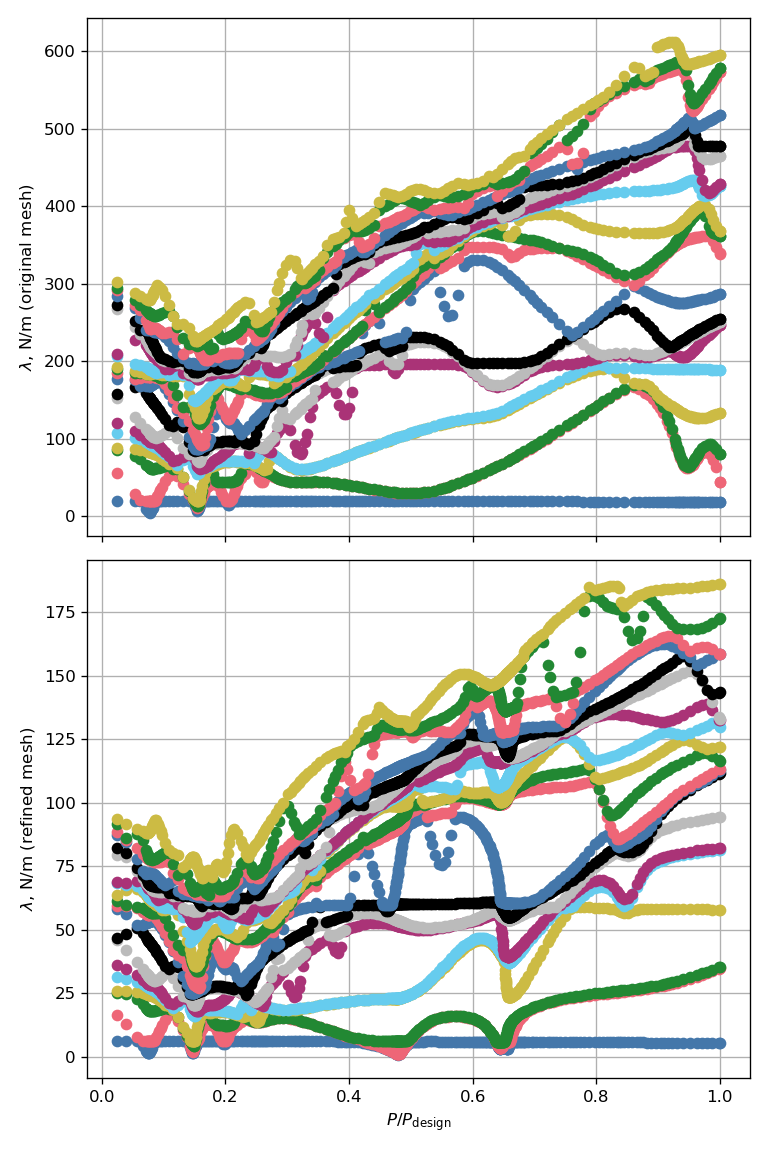

In [41]:
# Retrieve OP2 object of nonlinear analysis
key = "refined mesh"
sol_106_op2_dict[key] = nonlinear_problem['nastran_solver.op2']

# Read load and displacement history of benchmark analysis from op2 file
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2_dict[key])
nondimensional_loads[key] = applied_loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/DESIGN_LOAD

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues_dict[key] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
mapping_dict = {"original mesh": "nonlinearly optimized structure", "refined mesh": "refined mesh"}
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6.4, 4.8*2))
for count, (label, model) in enumerate(mapping_dict.items()):
    axes[count].plot(nondimensional_loads[model], eigenvalues_dict[model].T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
    axes[count].set_ylabel(f"$\lambda$, N/m ({label})")
    axes[count].grid(True)

# Finalize plot appearance
axes[count].set_xlabel("$P/P_\mathrm{design}$")
plt.tight_layout()  # adjust subplots' layout
plt.show()

As expected, we observe that the eigenvalues of the model employing the refined mesh are generally charaterized by a lower magnitude compared to those of the model employing the original mesh. In fact, it is well known that coarser meshes produce stiffer structural models, and this agrees with the higher eigenvalues of the model employing the original mesh, as they represent the stiffness of the corresponding principal stiffness directions.

The two eigenvalue diagrams show a good agreement for $P/P_\text{design}<0.3$, with several local minima captured by both meshes. However, the agreement degrades as the applied load increases. In fact, new local minima appear in the eigenvalue diagram of the model with the refined mesh, in particular at $P/P_\text{design}=0.48$ and between $0.64$ and $0.66$. These new local minima suggest that the model employing the refined mesh captures broken supercritical pitchforks that most probably appear also in the model employing the original mesh but only at much larger loads, given the higher stiffness associated to many of the principal stiffness directions.

However, both models do not predict any instability within the design load, suggesting that the suitability of the model employing the original mesh for the scope of the nonlinear structural stability optimization.

We now compare the load-displacement diagrams obtained with the two models, considering only the root and the tip displacements.

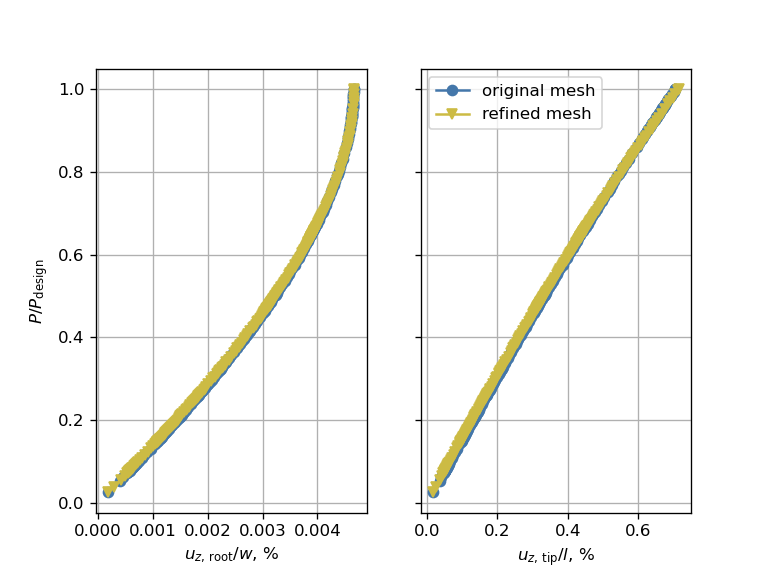

In [42]:
# Initialize plotting dictionaries
plot_nodes_dict = {"nonlinearly optimized structure": [ROOT_NODE_ID, TIP_MASTER_NODE_ID],
                   key: [refined_mesh_max_displacement_node_id, refined_mesh_tip_master_node_id]}
displacement_labels = ["u_{z,\,\mathrm{root}}/w", "u_{z,\,\mathrm{tip}}/l"]

# Create figure with two subplots corresponding to the two selected nodes
_, axes = plt.subplots(1, 2, sharey=True)

# Iterate over the plotting nodes
for i, ax in enumerate(axes):
    stable_lines = []  # list to store proxy artists for the legend
    
    # Iterate over the models with original and refined mesh
    for color_index, (label, model) in enumerate(mapping_dict.items()):
        _, _, displacements = pynastran_utils.read_load_displacement_history_from_op2(
            op2_object=sol_106_op2_dict[model], displacement_node_id=plot_nodes_dict[model][i])  # read displacements from OP2 object
        nondimensional_displacements = displacements[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/REFERENCE_LENGTHS[i + 1]  # nondimensionalize displacements
        plot_utils.plot_2d_load_displacements_stability(eigenvalues_dict[model], ax, nondimensional_displacements*100,
                                                        nondimensional_loads[model], MARKERS[color_index], COLORS[color_index])  # plot load-displacement curve highlighting stability
        stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[color_index], color=COLORS[color_index], label=label))  # create proxy artist for the legend
    
    # Set x-axis label of subplot and show grid
    ax.set_xlabel(f"${displacement_labels[i]}$, %")
    ax.grid(visible=True)

# Add proxy artist for unstable lines and create legend
axes[1].legend(handles=stable_lines)

# Set y-axis label and show plot
axes[0].set_ylabel("$P/P_\mathrm{design}$")
plt.show()

Both load-displacment diagrams show an excellent agreement, confirming the suitability of the model employing the original mesh for the scope of the nonlinear structural stability optimization.

Finally, we compare the deformation at design load.

Deformation at design load of original mesh:


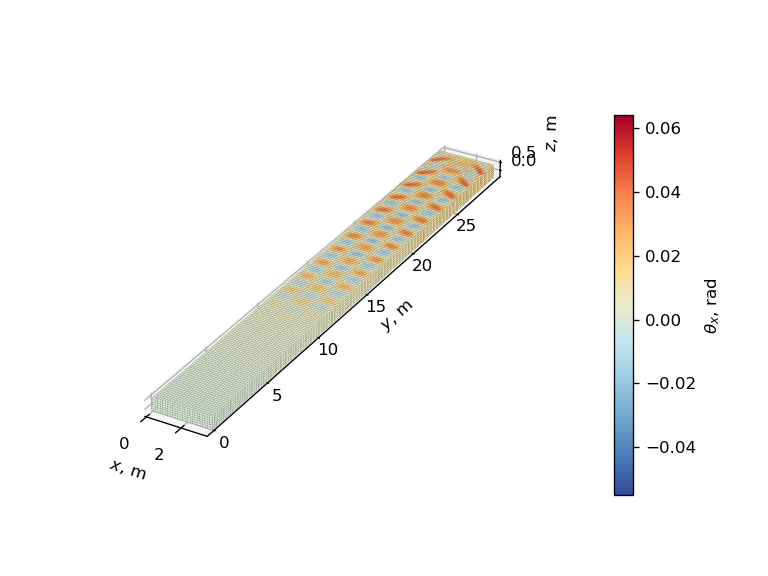

Deformation at design load of refined mesh:


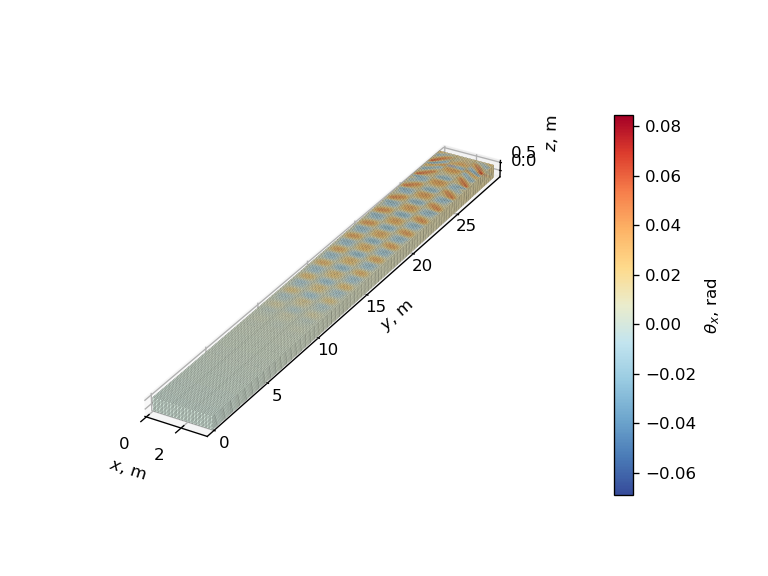

In [43]:
for label, model in mapping_dict.items():
    print(f"Deformation at design load of {label}:")
    _, ax, cbar = pynastran_utils.plot_static_deformation(op2_object=sol_106_op2_dict[model], subcase_id=FIRST_SUBCASE_ID,
                                                        displacement_component='rx', colormap='sunset', length_unit='m', unit_scale_factor=1e-3)  # plot deformation converting from mm to m
    adjust_3d_plot(ax, cbar)
    plt.show()

Also in this case we can observe a good agreement between the two deformations. The most significant difference is in the model with the refined mesh capturing with a higher resolution half-waves over the front and rear rib-stiffener bays close to the tip, oriented at approximately 45 degrees with respect to the beam's width. However, from a qualitative point of view, the deformation appear similar also in this region.

## Conclusion <a name="conclusion"></a>

***

In this notebook we performed a two-variables optimization of the CRM-like box beam, using a varying thickness over the length of the structure. We started by running a linear buckling optimization to find a suitable initial structure for the optimization with nonlinear structural stability constraints. The linear buckling optimization resulted in a 21.7% mass reduction with respect to the initial structure, by slightly increasing the root thickness and by almost halving the tip thickness. The critical buckling mode of the linearly optimized structure involved the middle region of the top skin along the length of the CRM-like box beam.

We then moved to the nonlinear structural stability optimization, starting from the design resulting from the linear buckling optimization. The optimization achieved a 11.7% mass reduction with respect to the linearly optimized structure, by further reinforcing the thickness at the root and further reducing the thickness at the tip. The final thickness distribution of the nonlinearly optimized structure ranged from 9.5 mm at the root to 1.2 mm at the tip.

Finally, we performed a mesh verification study on the nonliearly optimized structure to understand the influence of the mesh on the results of the optimization. Despite a few differences in the eigenvalue diagram, the model employing the original mesh showed a good agreement with the model employing the refined mesh in terms of load-displacement diagrams and deformations at the design load, demonstrating its suitability for the scope of the nonlinear structural stability optimization.